# Trends and Anomlaies in the Upwelling Indices

#### Climatologies (for UI<sub>Ek</sub>, UI<sub>SST</sub> and UI<sub>SSH</sub>)
1. Every week
    - trend, R2, p-value (whole period, last decade)
2. Seasonal mean
    - trend, R2, p-value (whole period, last decade)
    - mean for every degree lat
    - north - south
    - and other variations
3. Anomalies
4. Get data over entire ERA5 period (1940-2023)
    - MTSS and SST
    - calculate seasonal mean trends


In [1]:
## save figures
save_var = False

## Import Packages and Data

In [2]:
## import packages
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib
import cartopy.crs as ccrs
import os
import my_functions
import datetime
from scipy.stats import linregress
from scipy.stats import pearsonr
%matplotlib inline

In [285]:
## import data
os.chdir('/Users/marie-louisekorte/Documents/Uni Leipzig/Lisbon/Data.nosync/')
MTSS = xr.open_dataset('MTSS_weekly.nc')
UI_SST = xr.open_dataset('UI_SST.nc')
SST = xr.open_dataset('CoRTAD_weekly.nc')
SSH = xr.open_dataset('SSH_weekly.nc') # SSH IBI
Angles = xr.open_dataset('Angles_coast.nc')
# mid-shelf coordinates
mid_shelf_lat = np.genfromtxt('CoRTAD/lat_midshelf_CoRTAD.dat')[:,1]
mid_shelf_lon = np.genfromtxt('CoRTAD/lon_midshelf_CoRTAD.dat')[:,1]

In [183]:
## set dir where I want to save my figures
os.chdir('/Users/marie-louisekorte/Documents/Uni Leipzig/Lisbon/Iberian_Coast_Upwelling/Figures/Round II/')

## Data Prep

In [146]:
## calculate the UIs (and add mid_shelf mask)
# UI Ek
Ek = MTSS
Ek = my_functions.calc_upwelling_index(MTSS, MTSS.lat, MTSS.lon, MTSS.metss.where(MTSS.lsm), MTSS.mntss.where(MTSS.lsm),
                                       near_shore = True, angles = Angles.angle_phi)
Ek = my_functions.add_mid_shelf(Ek, mid_shelf_lat, mid_shelf_lon)

# UI SST and SSH
SST = my_functions.add_mid_shelf(SST, mid_shelf_lat, mid_shelf_lon)
SST['UI'] = SST.SST.where(SST.lon == -15.019103) - SST.SST.where(SST.mid_shelf).mean(dim = 'lon')
SST.UI.attrs.update({'Name' : 'SST upwelling index', 'Info' : 'SST at 15° - SST at mid-shelf', 'Sign' : 'positive inidcates upwelling'})

SSH = my_functions.add_mid_shelf(SSH, mid_shelf_lat, mid_shelf_lon)
SSH['UI'] = SSH.zos.where(SSH.lon == -10.5) - SSH.zos.where(SSH.mid_shelf).mean(dim = 'lon')
SSH.UI.attrs.update({'Name' : 'SSH upwelling index', 'Info' : 'SSH at 10.5°W - SSH at mid-shelf', 'Sign' : 'positive inidcates upwelling'})

In [147]:
## meridional mean
Ek = my_functions.calc_meridional_mean(Ek, lon = -10.5)
SST = my_functions.calc_meridional_mean(SST, lon = -15.019103)
UI_SST = my_functions.calc_meridional_mean(UI_SST, lon = -15)
SSH = my_functions.calc_meridional_mean(SSH, lon = -10.5)

In [148]:
## summer subset
Ek_summer = my_functions.subset_summer(Ek)
SST_summer = my_functions.subset_summer(SST)
UI_SST_summer = my_functions.subset_summer(UI_SST)
SSH_summer = my_functions.subset_summer(SSH)

In [149]:
# create Ek_ns dataset with meridional mean and summer subset
Ek_ns = Ek
Ek_ns = Ek_ns.drop_vars(["UI", "UI_mean"])
Ek_ns['UI'] = Ek_ns.UI_ns 
UI_mean = Ek_ns.UI.mean(dim = ['lat', 'lon'])
Ek_ns['UI_mean'] = UI_mean
Ek_ns_summer = my_functions.subset_summer(Ek_ns)

## Functions

In [212]:
## plot variable, give stats over whole period and last decade

def plot_trend(x_dates, y, col = 'darkcyan', title = 'Title', ylabel = 'Y axis', save = False, save_fig_as = 'UI':
    # get values for the trend line analysis
    fig = plt.figure(figsize = (9, 3))

    # calculate stats whole period
    x = np.arange(len(x_dates))
    regression = linregress(x, y)
    
    # define last decades in years and calculate stats
    last_10 = x_dates.dt.isocalendar().year.max().values - 9 # minus nine years because the last year is already fully included 
    x_dates_10 = np.delete(x_dates, (np.where(x_dates.dt.isocalendar().year < last_10)))
    x_10 = np.delete(x, (np.where(x_dates.dt.isocalendar().year < last_10)))
    y_10 = np.delete(y, (np.where(x_dates.dt.isocalendar().year < last_10)))
    regression_10 = linregress(x_10, y_10)
    
    # plot 
    # all data
    plt.plot(x_dates, y, marker = '.', markerfacecolor = col, alpha = 0.3, color = col)
    # trend whole period
    plt.plot(x_dates, x*regression.slope + regression.intercept, "k-", alpha = 0.8, lw = 1, label = 'Trend') 
    # last 10 years
    plt.plot(x_dates_10, x_10*regression_10.slope + regression_10.intercept, "k:", label = 'Trend last decade') 
    
    plt.legend(bbox_to_anchor=(1.0, 1), loc = 'upper left', labelspacing = 6.2, edgecolor = 'none', facecolor = 'none')
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel(ylabel)
    plt.xlim(dates.date2num(['1980']), dates.date2num(['2025']))
    plt.grid(lw = 0.5)
   
    # print stats
    plt.figtext(0.79, 0.6, r'  $R^2$:' f'{(regression.rvalue**2):.5f} \n  Trend: {regression.slope:.5f} \n  p-value: {regression.pvalue:.5f}')
    plt.figtext(0.79, 0.26, r'  $R^2$:' f'{(regression_10.rvalue**2):.5f} \n  Trend: {regression_10.slope:.5f} \n  p-value: {regression_10.pvalue:.5f}')

    fig.tight_layout()
    if save:
        fig.savefig(f'{save_fig_as}.png', dpi = 300, bbox_inches='tight')

In [215]:
## plot variable, give stats over whole period and last decade

def plot_trend_2(x_dates, y, col = 'darkcyan', title = 'Title', ylabel = 'Y axis', save = False, save_fig_as = 'UI', long = False):
    # get values for the trend line analysis
    fig = plt.figure(figsize = (10, 3))

    # calculate stats whole period
    x = np.arange(len(x_dates))
    regression = linregress(x, y)
    
    # define last decades in years and calculate stats
    last_10 = x_dates.dt.isocalendar().year.max().values - 9 # minus nine years because the last year is already fully included 
    x_dates_10 = np.delete(x_dates, (np.where(x_dates.dt.isocalendar().year < last_10)))
    x_10 = np.delete(x, (np.where(x_dates.dt.isocalendar().year < last_10)))
    y_10 = np.delete(y, (np.where(x_dates.dt.isocalendar().year < last_10)))
    regression_10 = linregress(x_10, y_10)

    # define second last decades in years and calculate stats
    last_20_min = x_dates.dt.isocalendar().year.max().values - 19  # need to define min and max
    last_20_max = x_dates.dt.isocalendar().year.max().values - 10 
    x_dates_20 = np.delete(x_dates, (np.where((x_dates.dt.isocalendar().year < last_20_min) | (x_dates.dt.isocalendar().year > last_20_max))))
    x_20 = np.delete(x, (np.where((x_dates.dt.isocalendar().year < last_20_min) | (x_dates.dt.isocalendar().year > last_20_max))))
    y_20 = np.delete(y, (np.where((x_dates.dt.isocalendar().year < last_20_min) | (x_dates.dt.isocalendar().year > last_20_max))))
    regression_20 = linregress(x_20, y_20)
    
    # plot 
    # all data
    plt.plot(x_dates, y, marker = '.', markerfacecolor = col, alpha = 0.3, color = col)
    # trend whole period
    plt.plot(x_dates, x*regression.slope + regression.intercept, "k-", alpha = 0.8, lw = 1, label = 'Trend') 
    # last 10 years
    plt.plot(x_dates_10, x_10*regression_10.slope + regression_10.intercept, "k:", label = 'Trend last decade') 
    # 10 years before that ('second last' decade)
    plt.plot(x_dates_20, x_20*regression_20.slope + regression_20.intercept, "k--", lw = 1, label = "Trend 'second last' decade") 
    
    plt.legend(bbox_to_anchor=(1.01, 1.1), loc = 'upper left', labelspacing = 6, edgecolor = 'none', facecolor = 'none', fontsize = 'small')
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel(ylabel)
    plt.xlim(dates.date2num(['1980']), dates.date2num(['2025']))
    if long:
        plt.xlim(dates.date2num(['1938']), dates.date2num(['2025']))
    plt.grid(lw = 0.5)
   
    # print stats
    plt.figtext(0.79, 0.69, r'  $R^2$:' f'{(regression.rvalue**2):.5f} \n  Trend: {regression.slope:.5f} \n  p-value: {regression.pvalue:.5f}', size = 'small')
    plt.figtext(0.79, 0.42, r'  $R^2$:' f'{(regression_10.rvalue**2):.5f} \n  Trend: {regression_10.slope:.5f} \n  p-value: {regression_10.pvalue:.5f}', size = 'small')
    plt.figtext(0.79, 0.15, r'  $R^2$:' f'{(regression_20.rvalue**2):.5f} \n  Trend: {regression_20.slope:.5f} \n  p-value: {regression_20.pvalue:.5f}', size = 'small')

    fig.tight_layout()
    if save:
        fig.savefig(f'{save_fig_as}.png', dpi = 300, bbox_inches='tight')

## **UI<sub>Ek</sub> _______________________________________________________________________________________________________________**

### UI<sub>Ek</sub> Trend

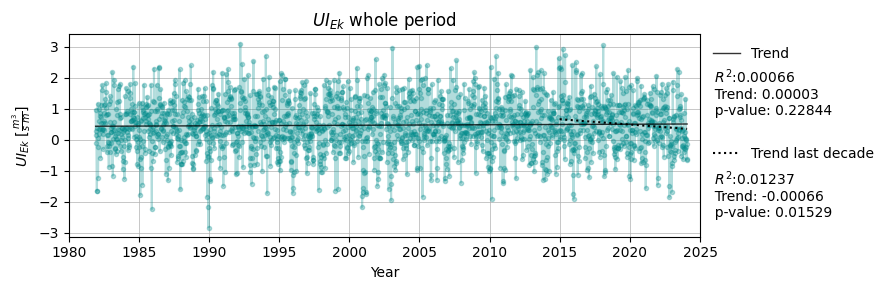

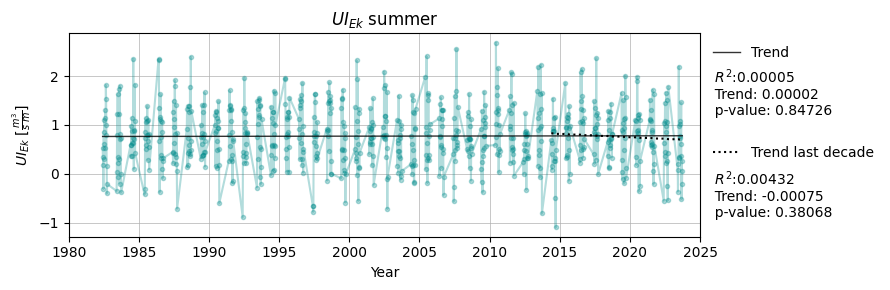

In [152]:
plot_trend(Ek.time, Ek.UI_mean, title = r'$UI_{Ek}$ whole period', ylabel = r'$UI_{Ek} \ [\frac{m^3}{s \ m}]$')
plot_trend(Ek_summer.time, Ek_summer.UI_mean, title = r'$UI_{Ek}$ summer', ylabel = r'$UI_{Ek} \ [\frac{m^3}{s \ m}]$',
          save = save_var, save_fig_as = 'UI_Ek_summer_all')

### UI<sub>Ek</sub> Seasonal mean

In [139]:
# get seasonal summer mean -› easier to read plots (has effect on stats I calculate)
Ek_summer_mean = Ek_summer.resample(time = 'YE', label = 'left').mean(dim = 'time') # label is assigned to start of year
Ek_ns_summer_mean = Ek_ns_summer.resample(time = 'YE', label = 'left').mean(dim = 'time') # label is assigned to start of year

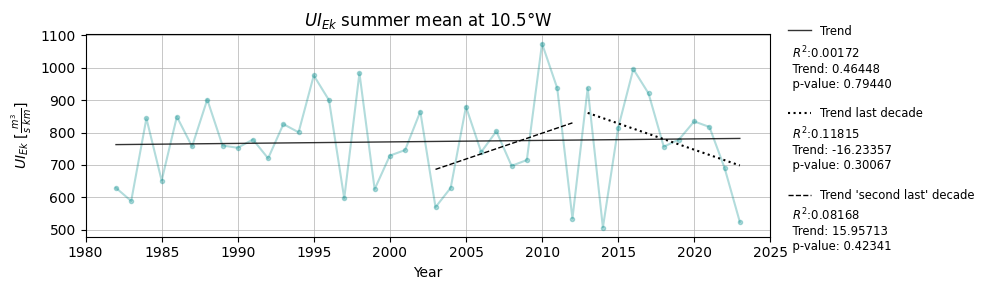

In [140]:
# at 10.5°
plot_trend_2(Ek_summer_mean.time, Ek_summer_mean.UI_mean * 1000, title = r'$UI_{Ek}$ summer mean at 10.5°W', 
           ylabel = r'$UI_{Ek} \ [\frac{m^3}{s \ km}]$', save = save_var, save_fig_as = 'UI_Ek_summer_seasonal_mean')

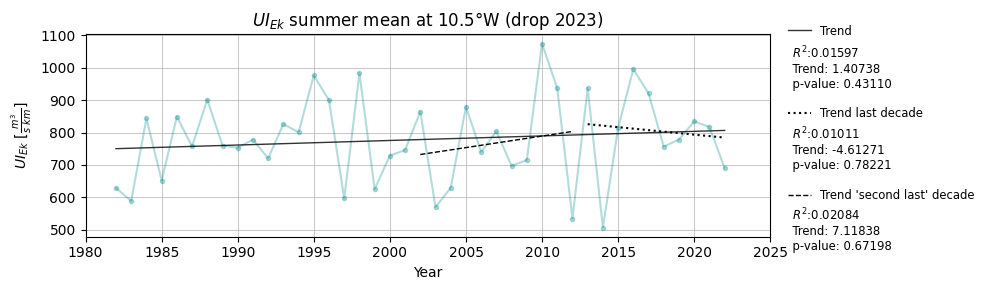

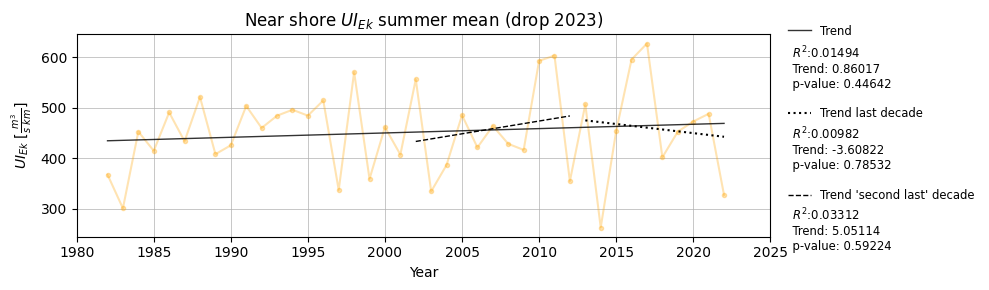

In [154]:
## exclude 2023 -> very extreme heatwave that year, anomalous SLP during June (very weak Azores high) -> associated with low winds!!
# calculate the mean over the summer months
plot_trend_2(Ek_summer_mean.isel(time = slice(0, -1)).time, Ek_summer_mean.isel(time = slice(0, -1)).UI_mean * 1000, title = r'$UI_{Ek}$ summer mean at 10.5°W (drop 2023)', 
           ylabel = r'$UI_{Ek} \ [\frac{m^3}{s \ km}]$', save = save_var, save_fig_as = 'UI_Ek_summer_seasonal_mean_no_2023_2')

## just removing that last year of data has quite a large impact on the trend impact 
# 2012 and 2014 are similarly 'bad upwelling summers' -> is this due to similar SLP patterns 

plot_trend_2(Ek_ns_summer_mean.isel(time = slice(0, -1)).time, Ek_ns_summer_mean.isel(time = slice(0, -1)).UI_mean * 1000, title = r'Near shore $UI_{Ek}$ summer mean (drop 2023)', 
           col = 'orange', ylabel = r'$UI_{Ek} \ [\frac{m^3}{s \ km}]$', save = save_var, save_fig_as = 'UI_Ek_ns_summer_seasonal_mean_no_2023')


In [142]:
Ek_August_mean =  Ek.where(Ek.month == 'Aug', drop = True).resample(time = 'YE', label = 'left').mean(dim = 'time')

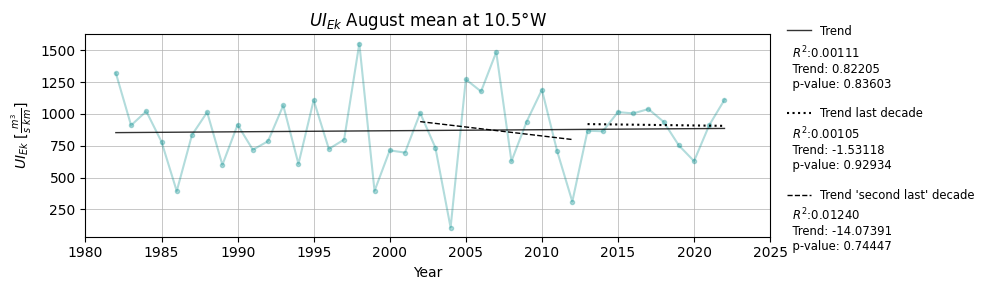

In [90]:
# at 10.5°
plot_trend_2(Ek_August_mean.isel(time = slice(0, -1)).time, Ek_August_mean.isel(time = slice(0, -1)).UI_mean * 1000, title = r'$UI_{Ek}$ August mean at 10.5°W', 
           ylabel = r'$UI_{Ek} \ [\frac{m^3}{s \ km}]$', save = save_var, save_fig_as = 'UI_Ek_summer_seasonal_mean')

#### Move location
- mid shelf
- 10.5°W
- 11.5°W
- 12.5°W
- 13.5°W

Mean mid-shelf: 0.772


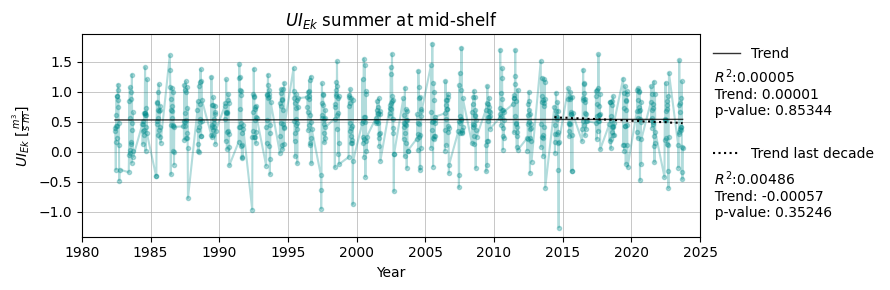

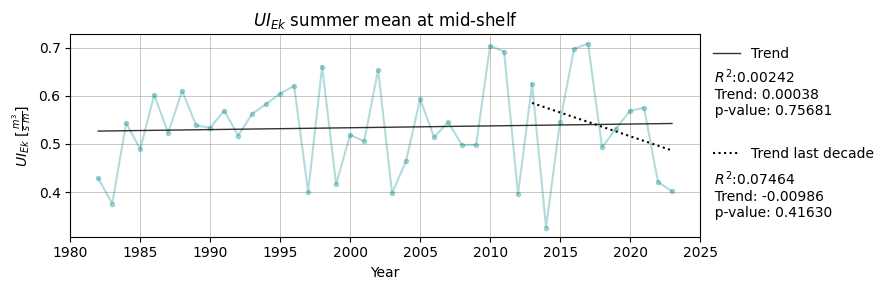

In [91]:
## with meridional mean at mid-shelf
# meridional mean 
Ek_summer_mid_shelf = Ek_summer.where(Ek_summer.mid_shelf, drop = True).mean(dim = 'lon').mean(dim = 'lat') # reduce to 1D index (mean at mid-shelf)
# calculate the mean over the summer months
Ek_summer_mean_mid_shelf = Ek_summer_mid_shelf.resample(time = 'YE', label = 'left').mean(dim = 'time') # label is assigned to start of year

print(f'Mean mid-shelf: {Ek_summer_mean_mid_shelf.UI_mean.mean():.3f}')

plot_trend(Ek_summer_mid_shelf.time, Ek_summer_mid_shelf.UI, title = (r'$UI_{Ek}$ summer at mid-shelf'), 
           ylabel = r'$UI_{Ek} \ [\frac{m^3}{s \ m}]$')
plot_trend(Ek_summer_mean_mid_shelf.time, Ek_summer_mean_mid_shelf.UI, title = (r'$UI_{Ek}$ summer mean at mid-shelf'), 
           ylabel = r'$UI_{Ek} \ [\frac{m^3}{s \ m}]$')

Mean 10.0°W: 0.767
Mean 10.25°W: 0.774
Mean 10.5°W: 0.772
Mean 10.75°W: 0.765
Mean 11.0°W: 0.751
Mean 11.25°W: 0.739
Mean 11.5°W: 0.722
Mean 11.75°W: 0.704
Mean 12.0°W: 0.685
Mean 12.25°W: 0.665
Mean 12.5°W: 0.645
Mean 12.75°W: 0.626
Mean 13.0°W: 0.604
Mean 13.25°W: 0.584
Mean 13.5°W: 0.564
Mean 13.75°W: 0.543
Mean 14.0°W: 0.525
Mean 14.25°W: 0.506
Mean 14.5°W: 0.487
Mean 14.75°W: 0.470


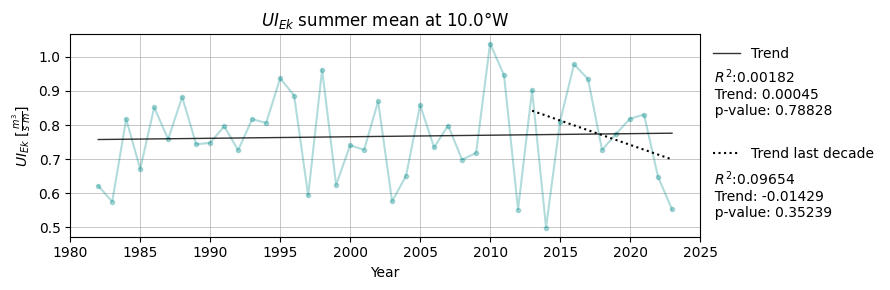

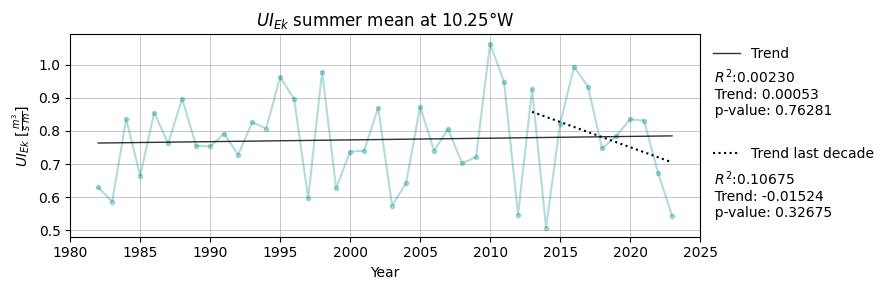

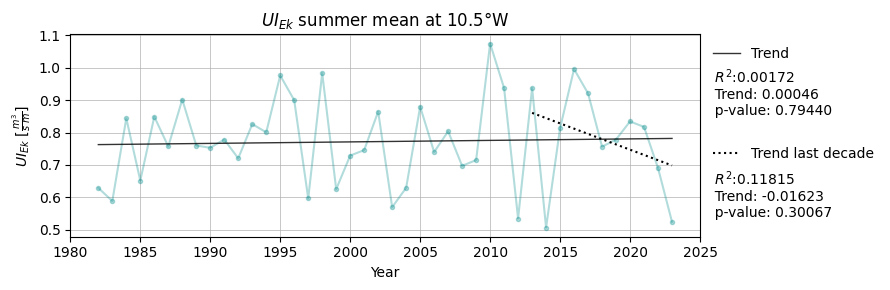

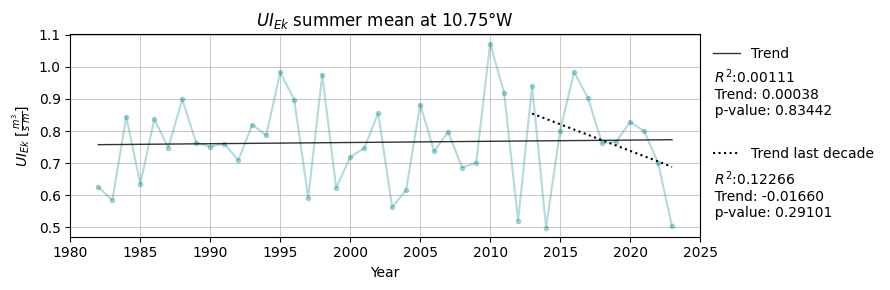

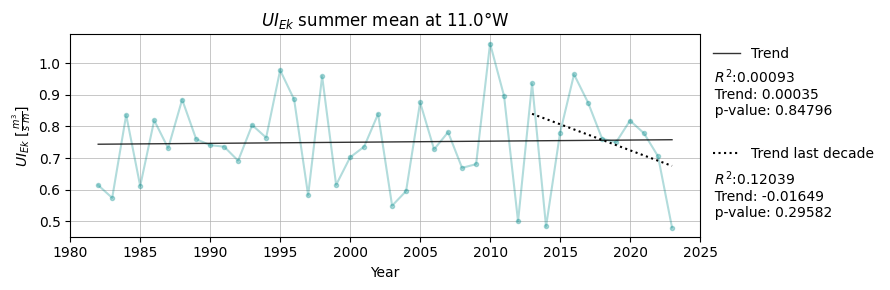

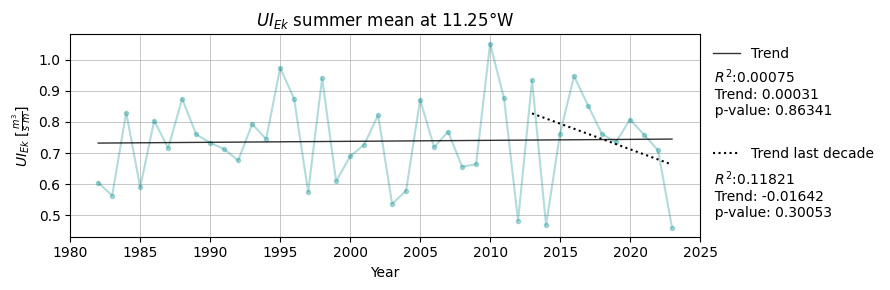

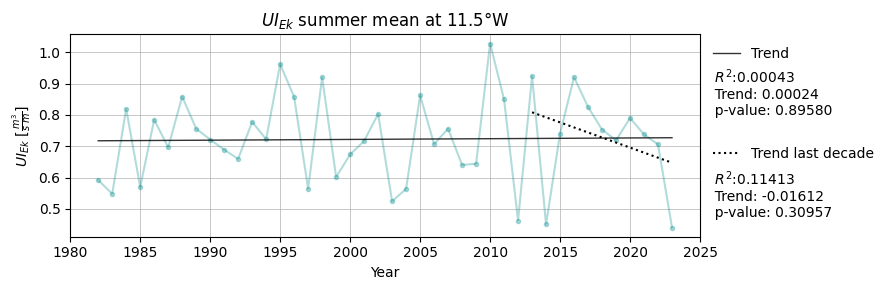

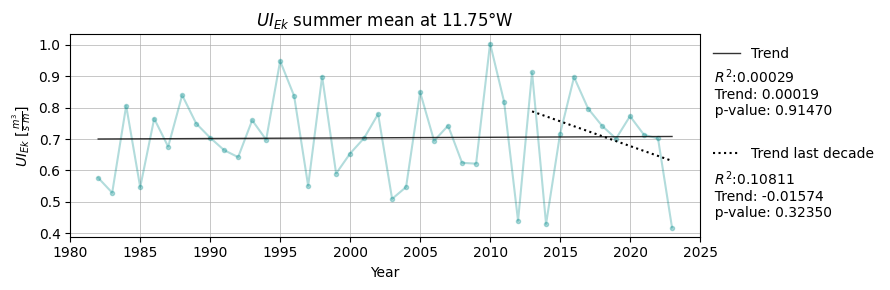

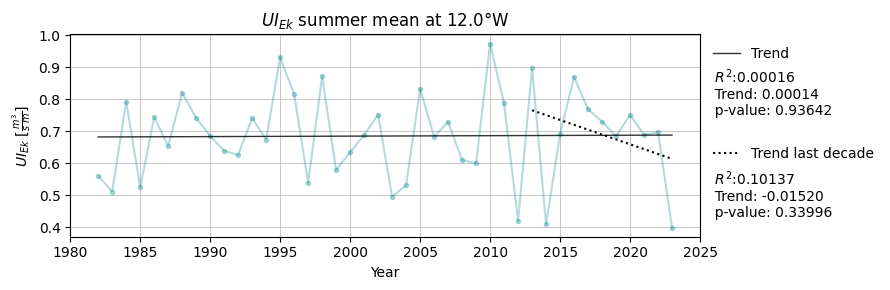

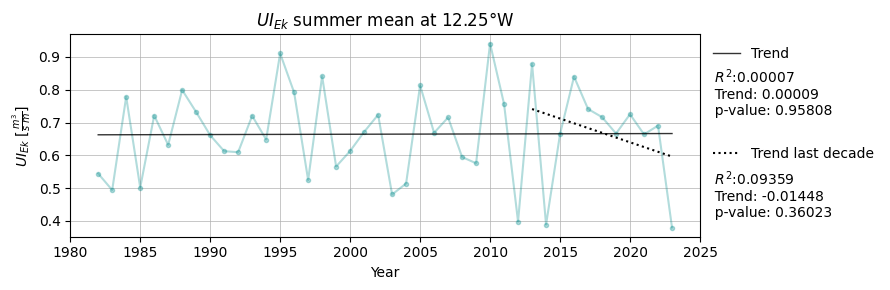

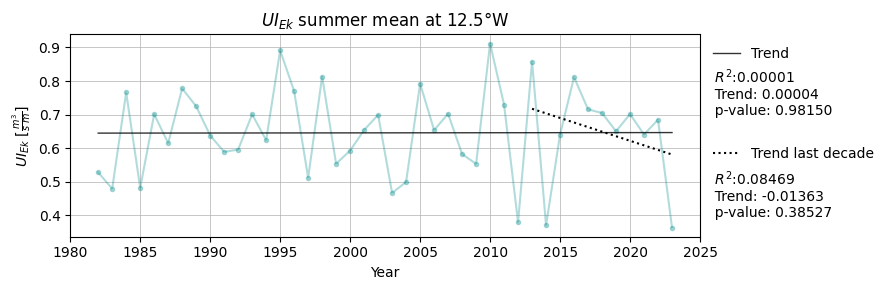

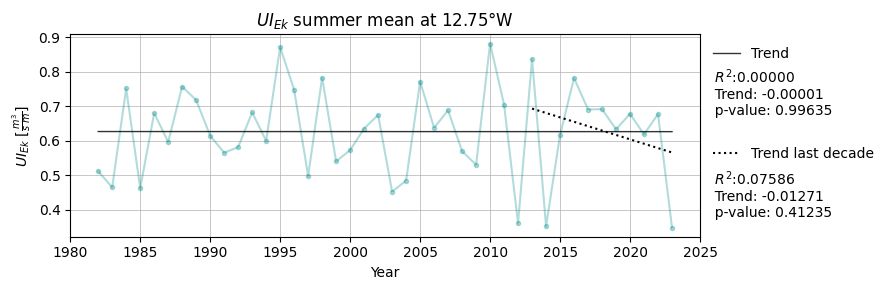

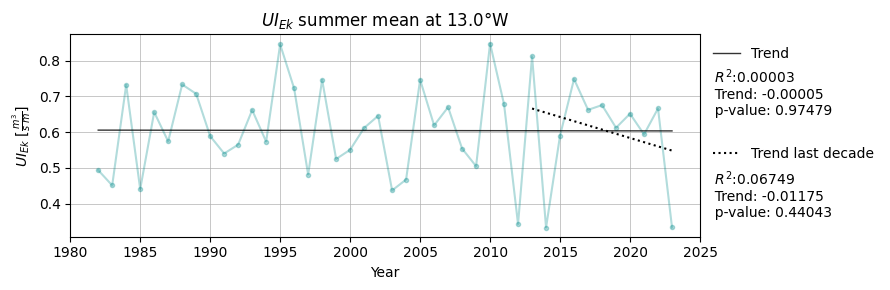

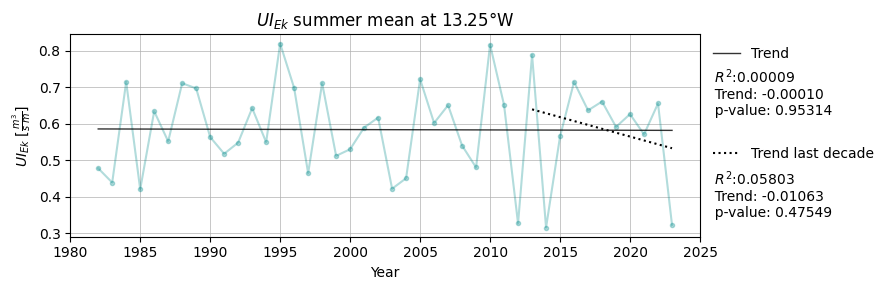

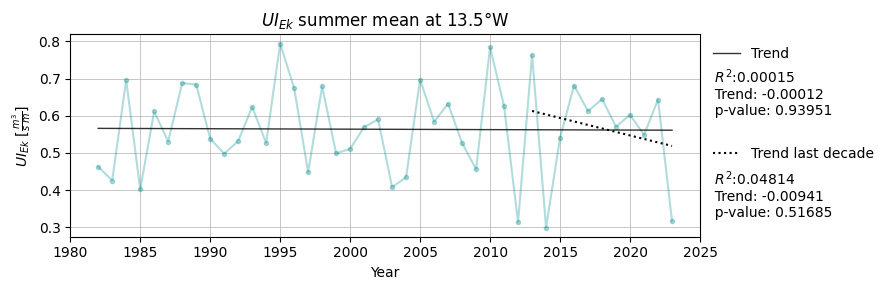

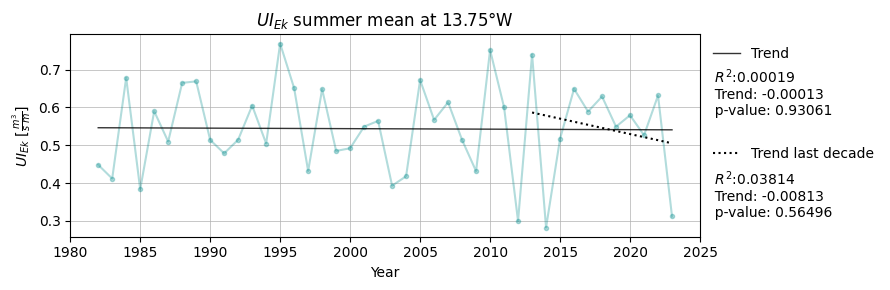

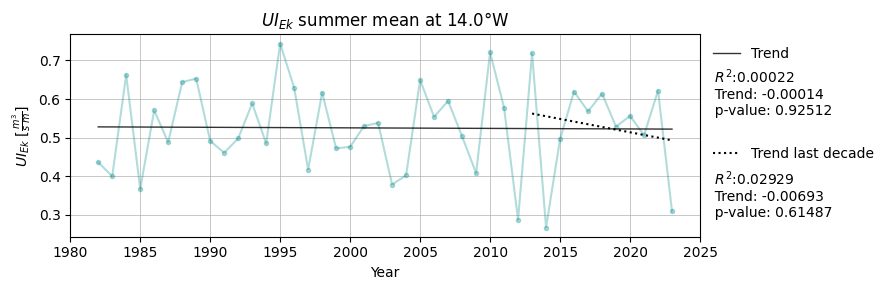

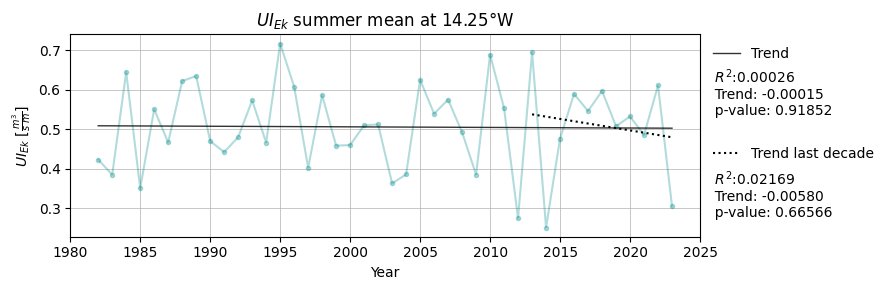

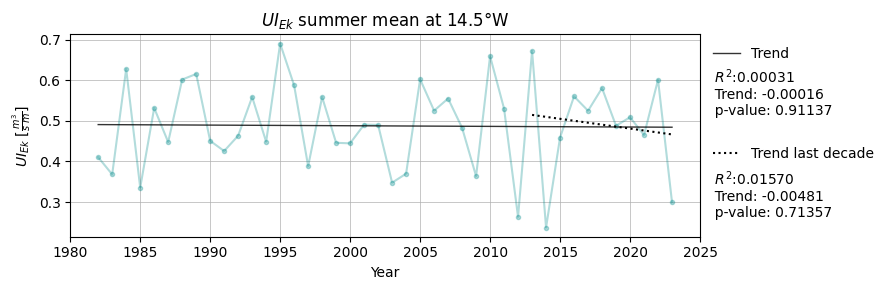

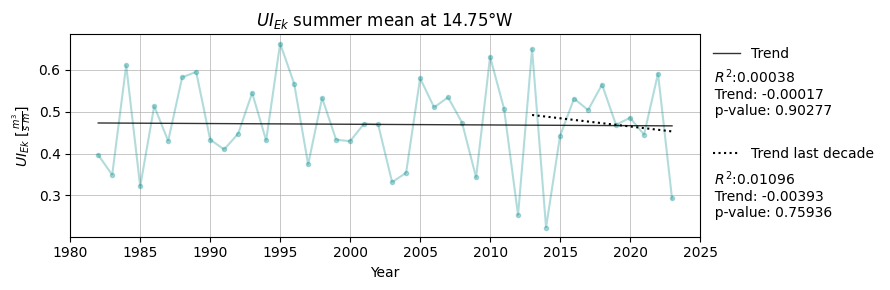

In [92]:
## with meridional mean at other longitudes
for lons in np.arange(-10, -15, -0.25):
    # meridional mean  
    Ek_summer_lon = my_functions.calc_meridional_mean(Ek_summer, lon = lons)
    # calculate the mean over the summer months
    Ek_summer_mean_lon = Ek_summer_lon.resample(time = 'YE', label = 'left').mean(dim = 'time') # label is assigned to start of year

    print(f'Mean {lons * -1}°W: {Ek_summer_mean_lon.UI_mean.mean():.3f}')
    plot_trend(Ek_summer_mean_lon.time, Ek_summer_mean_lon.UI_mean, title = (r'$UI_{Ek}$ summer mean at ' f'{lons * -1}°W'), 
               ylabel = r'$UI_{Ek} \ [\frac{m^3}{s \ m}]$')

# upwelling index is highest at 10.5°W

#### Effect of other things
- North south split at 41.5° 
- shoerter summer UI -> (Jun - Aug)
- winter UI development?? (Nov - Mar)
- differnt location -› different lats

In [93]:
# North UI
Ek_N = Ek.drop_vars('UI_mean').sel(lat = slice(41.5, None))
Ek_S = Ek.drop_vars('UI_mean').sel(lat = slice(None, 41.5))

In [94]:
Ek_N = my_functions.calc_meridional_mean(Ek_N, lon = -10.5)
Ek_S = my_functions.calc_meridional_mean(Ek_S, lon = -10.5)

In [95]:
Ek_N_summer = my_functions.subset_summer(Ek_N)
Ek_S_summer = my_functions.subset_summer(Ek_S)

In [96]:
Ek_N_summer_mean = Ek_N_summer.resample(time = 'YE', label = 'left').mean(dim = 'time')
Ek_S_summer_mean = Ek_S_summer.resample(time = 'YE', label = 'left').mean(dim = 'time')

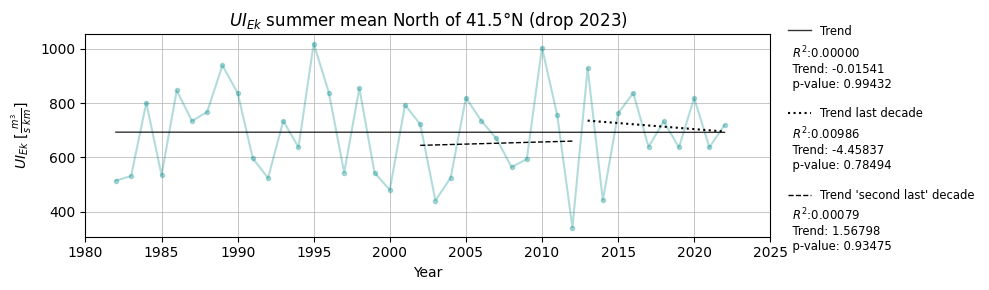

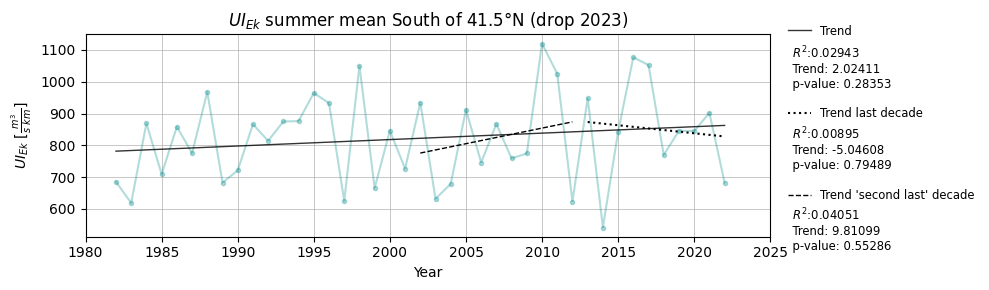

In [155]:
plot_trend_2(Ek_N_summer_mean.time.sel(time = slice(None, '31-12-2021')), Ek_N_summer_mean.UI_mean.sel(time = slice(None, '31-12-2021')) * 1000, title = r'$UI_{Ek}$ summer mean North of 41.5°N (drop 2023)', ylabel = r'$UI_{Ek} \ [\frac{m^3}{s \ km}]$',
          save = save_var, save_fig_as = 'UI_Ek_summer_seasonal_mean_no_2023_North')
plot_trend_2(Ek_S_summer_mean.time.sel(time = slice(None, '31-12-2021')), Ek_S_summer_mean.UI_mean.sel(time = slice(None, '31-12-2021')) * 1000, title = r'$UI_{Ek}$ summer mean South of 41.5°N ((drop 2023)', ylabel = r'$UI_{Ek} \ [\frac{m^3}{s \ km}]$',
          save = save_var, save_fig_as = 'UI_Ek_summer_seasonal_mean_no_2023_South')

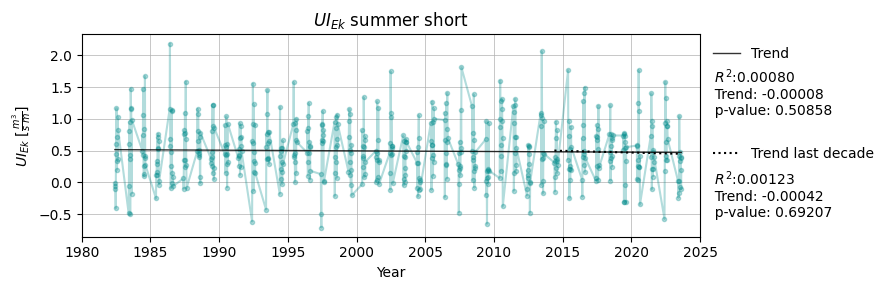

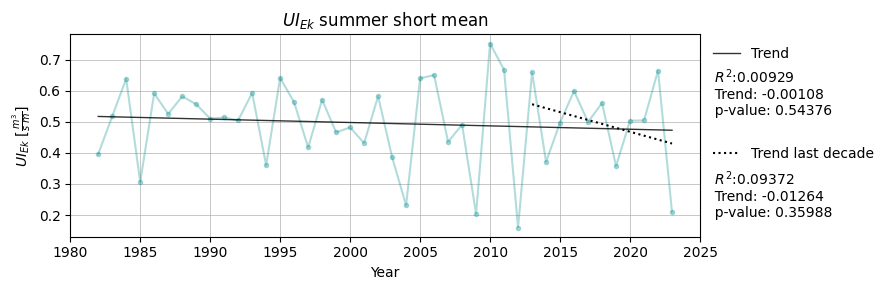

In [98]:
## winter UI
# ... not the most elegant solution but it will do 
Ek_summer_short = Ek_summer.where(Ek_summer.month != 'Sep', drop = True)

# plot all weeks
plot_trend(Ek_summer_short.time, Ek_summer_short.UI_mean, title = r'$UI_{Ek}$ summer short', 
           ylabel = r'$UI_{Ek} \ [\frac{m^3}{s \ m}]$')
# plot short summer mean
Ek_summer_short_mean = Ek_summer_short.resample(time = 'YE', label = 'left').mean(dim = 'time') # label is assigned to start of year
plot_trend(Ek_summer_short_mean.time, Ek_summer_short_mean.UI_mean, title = r'$UI_{Ek}$ summer short mean', 
           ylabel = r'$UI_{Ek} \ [\frac{m^3}{s \ m}]$')

## the values are overall higher if I exclude September

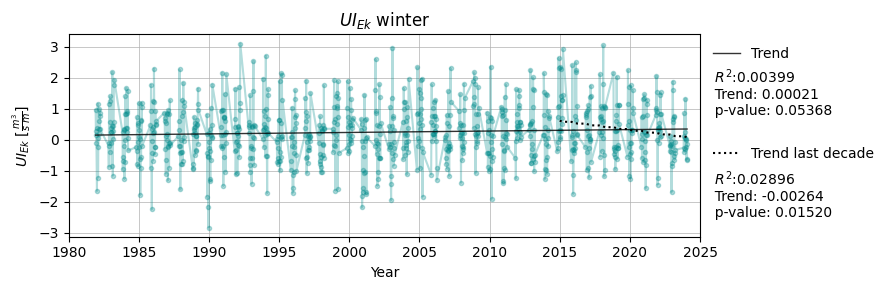

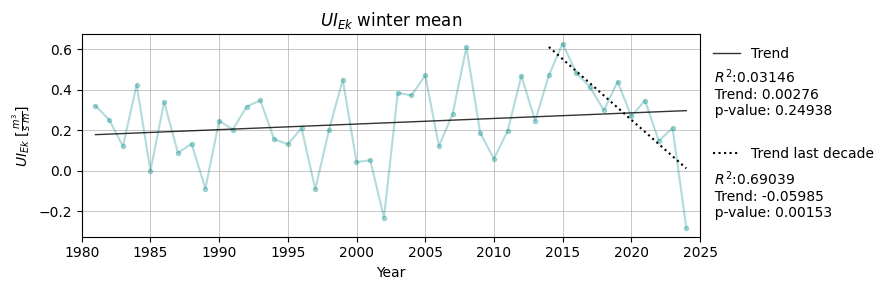

In [99]:
## winter UI
# ... not the most elegant solution but it will do 
Ek_weeks = my_functions.add_week_and_month(Ek)
Ek_winter = Ek_weeks.where((Ek_weeks.month == 'Nov') | (Ek_weeks.month == 'Dec') | (Ek_weeks.month == 'Jan') | 
                           (Ek_weeks.month == 'Feb') | (Ek_weeks.month == 'Mar'), drop = True)
# plot all winter weeks
plot_trend(Ek_winter.time, Ek_winter.UI_mean, title = r'$UI_{Ek}$ winter', 
           ylabel = r'$UI_{Ek} \ [\frac{m^3}{s \ m}]$')
# plot winter mean
Ek_winter_mean = Ek_winter.resample(time = 'YE', label = 'left').mean(dim = 'time') # label is assigned to start of year
plot_trend(Ek_winter_mean.time, Ek_winter_mean.UI_mean, title = r'$UI_{Ek}$ winter mean', 
           ylabel = r'$UI_{Ek} \ [\frac{m^3}{s \ m}]$')

## quite a lot of variability but slight positive trend ... 

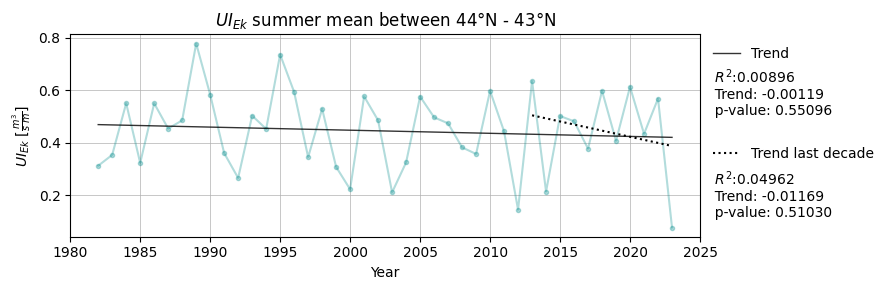

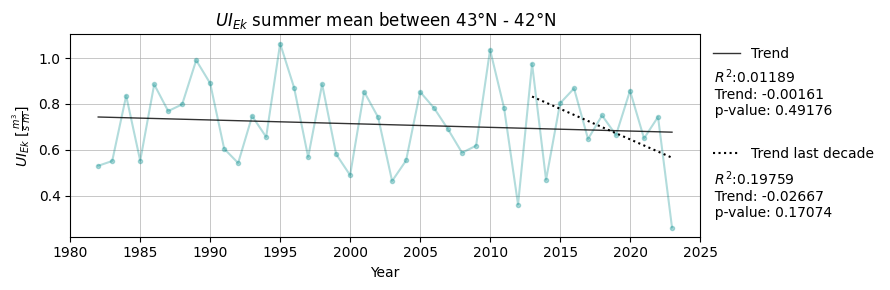

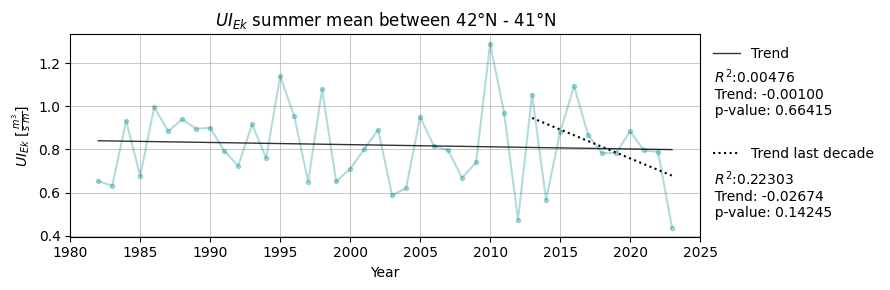

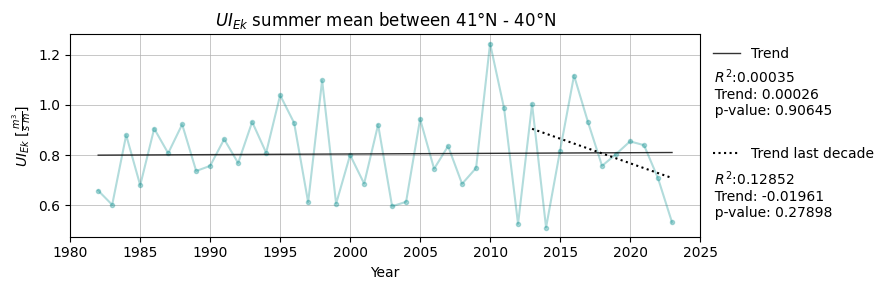

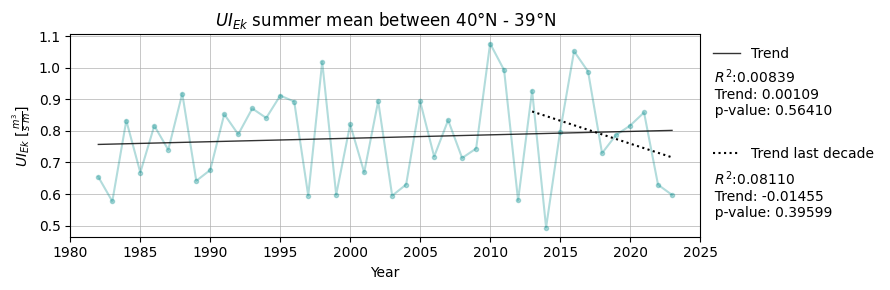

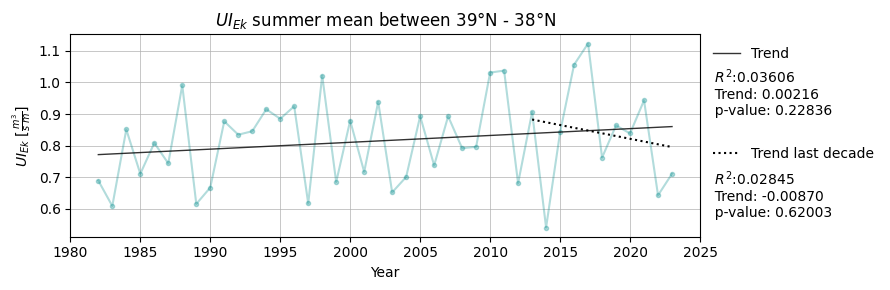

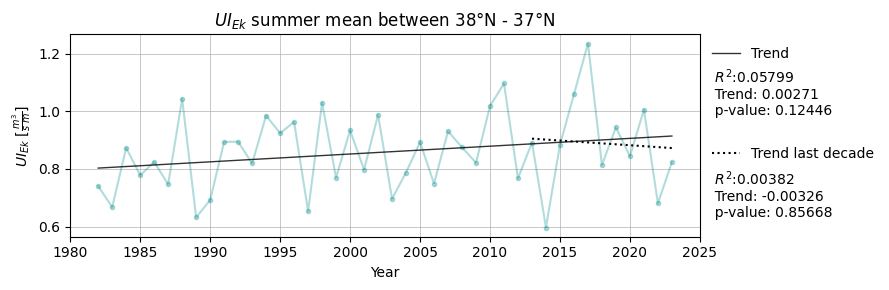

In [100]:
## the summer UI Ek for every degree lat (mean around that latitude)
for lats in np.arange(44, 37, -1): # from 44°N coast has more of a SE-NW direction
    y = Ek_summer_mean.UI.sel(lon = -10.5, method = 'nearest').sel(lat = slice(lats-1, lats)).mean(dim = 'lat')
    plot_trend(Ek_summer_mean.time, y, # col = 'steelblue', 
               title = (r'$UI_{Ek}$ summer mean' f' between {lats}°N - {lats - 1}°N'), 
               ylabel = r'$UI_{Ek} \ [\frac{m^3}{s \ m}]$') 

### UI<sub>Ek</sub> Anomalies

Summer mean UI Ek 0.772


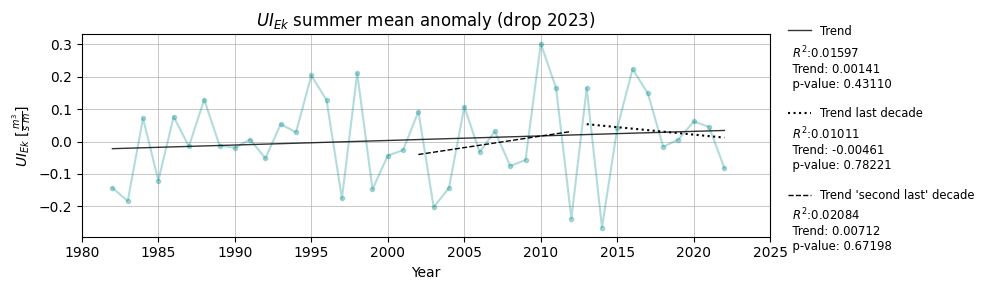

In [170]:
Ek_anomaly = Ek_summer_mean.UI_mean - Ek_summer_mean.UI_mean.mean(dim = 'time')
print('Summer mean UI Ek', np.round(Ek_summer_mean.UI_mean.mean(dim = 'time').values, 3))
plot_trend_2(Ek_summer_mean.time.isel(time = slice(0,-1)), Ek_anomaly[0:-1], title = r'$UI_{Ek}$ summer mean anomaly (drop 2023)', 
           ylabel = r'$UI_{Ek} \ [\frac{m^3}{s \ m}]$', save = True, save_fig_as = 'UI_Ek_summer_anomaly_trends')

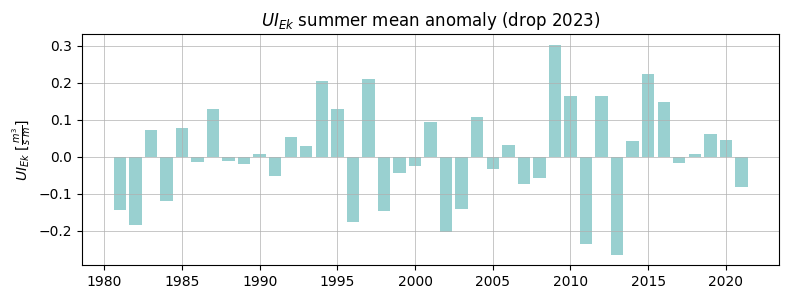

In [169]:
# same data as above but bar plot for visualisation (common for anomaly visualisation??) 
fig = plt.figure(figsize = (9,3))
plt.bar(Ek_anomaly.time.dt.year.isel(time = slice(0,-1)), Ek_anomaly[0:-1], color = 'darkcyan', alpha = 0.4)
plt.title(r'$UI_{Ek}$ summer mean anomaly (drop 2023)')
plt.ylabel(r'$UI_{Ek} \ [\frac{m^3}{s \ m}]$')
plt.grid(lw = 0.5)
plt.savefig('UI_Ek_summer_mean_anomaly.png', dpi = 300, bbox_inches = 'tight')

## **UI<sub>SST</sub> _______________________________________________________________________________________________________________**

### UI<sub>SST</sub> Trend

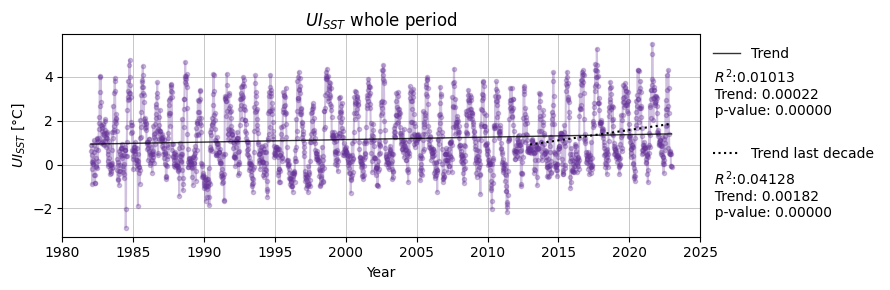

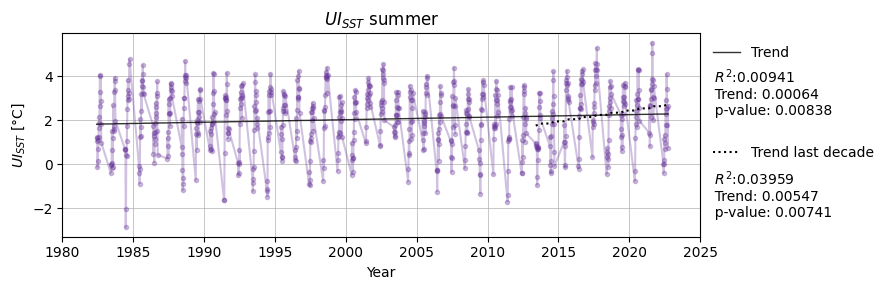

In [27]:
plot_trend(SST.time, SST.UI_mean, col = 'rebeccapurple',
           title = r'$UI_{SST}$ whole period', ylabel = r'$UI_{SST}$ [°C]')
plot_trend(SST_summer.time, SST_summer.UI_mean, col = 'rebeccapurple',
           title = r'$UI_{SST}$ summer', ylabel = r'$UI_{SST}$ [°C]',
           save = save_var, save_fig_as = 'UI_SST_summer_all')

### UI<sub>SST</sub> Seasonal mean

In [28]:
# calculate the mean over the summer months
SST_summer_mean = SST_summer.resample(time = 'YE', label = 'left').mean(dim = 'time') # label is assigned to start of year

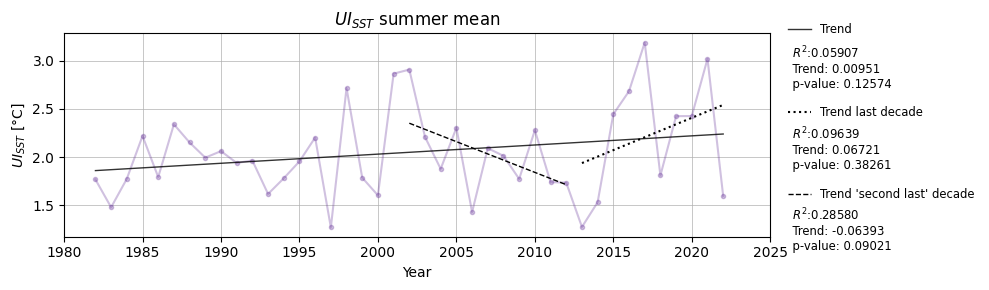

In [159]:
plot_trend_2(SST_summer_mean.time, SST_summer_mean.UI_mean, col = 'rebeccapurple', title = r'$UI_{SST}$ summer mean', 
           ylabel = r'$UI_{SST}$ [°C]', save = save_var, save_fig_as = 'UI_SST_summer_seasonal_mean_2')

#### UI<sub>SST</sub> North vs South

In [171]:
# North UI
SST_N = SST.drop_vars('UI_mean').sel(lat = slice(41.5, None))
SST_S = SST.drop_vars('UI_mean').sel(lat = slice(None, 41.5))

In [179]:
SST_N = my_functions.calc_meridional_mean(SST_N, lon = -15.019103)
SST_S = my_functions.calc_meridional_mean(SST_S, lon = -15.019103)

In [180]:
SST_N_summer = my_functions.subset_summer(SST_N)
SST_S_summer = my_functions.subset_summer(SST_S)

In [181]:
SST_N_summer_mean = SST_N_summer.resample(time = 'YE', label = 'left').mean(dim = 'time')
SST_S_summer_mean = SST_S_summer.resample(time = 'YE', label = 'left').mean(dim = 'time')

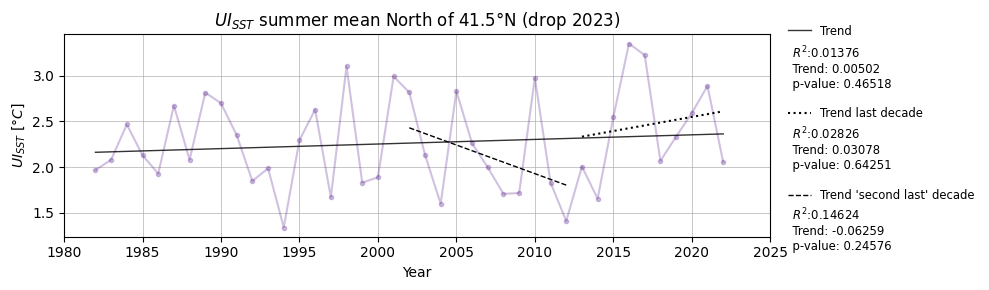

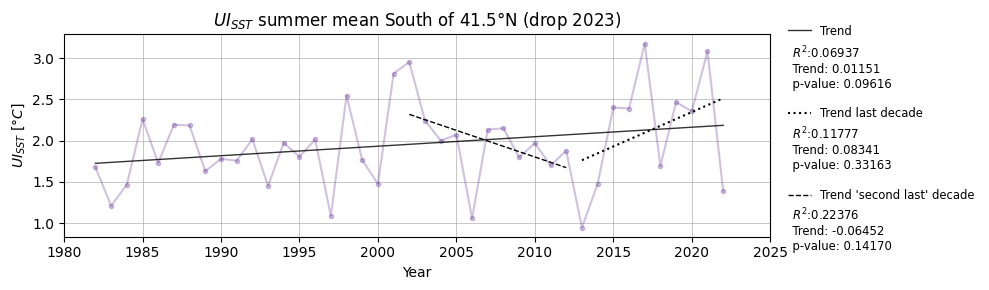

In [184]:
plot_trend_2(SST_N_summer_mean.time, SST_N_summer_mean.UI_mean, col = 'rebeccapurple', title = r'$UI_{SST}$ summer mean North of 41.5°N (drop 2023)', ylabel = r'$UI_{SST} \ [°C]$',
          save = True, save_fig_as = 'UI_SST_summer_seasonal_mean_no_2023_North')
plot_trend_2(SST_S_summer_mean.time, SST_S_summer_mean.UI_mean, col = 'rebeccapurple', title = r'$UI_{SST}$ summer mean South of 41.5°N (drop 2023)', ylabel = r'$UI_{SST} \ [°C]$',
          save = True, save_fig_as = 'UI_SST_summer_seasonal_mean_no_2023_South')

#### UI<sub>SST</sub> at different lats

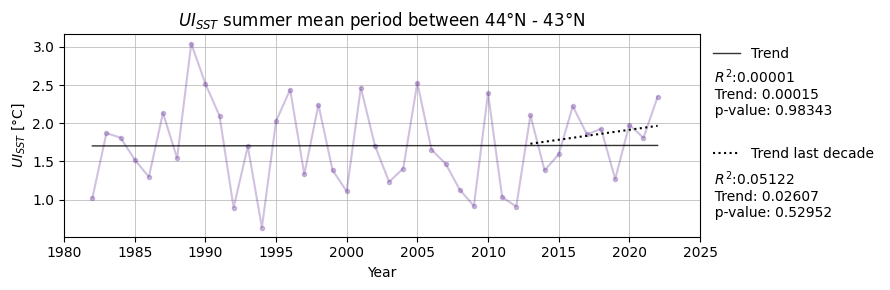

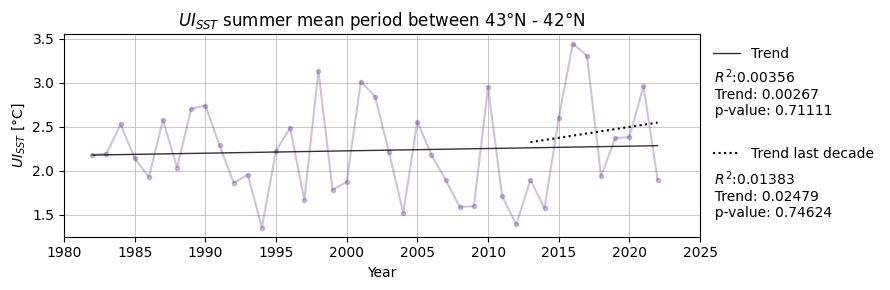

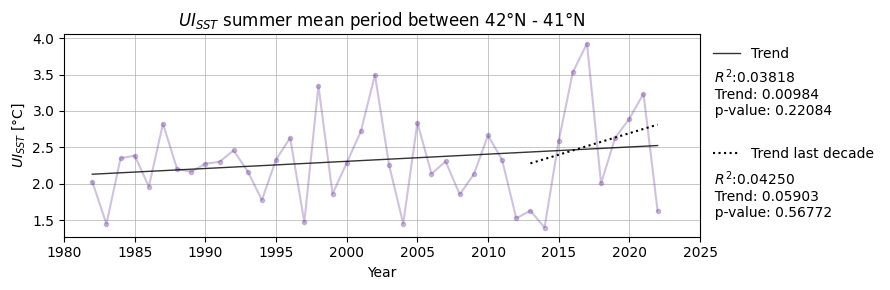

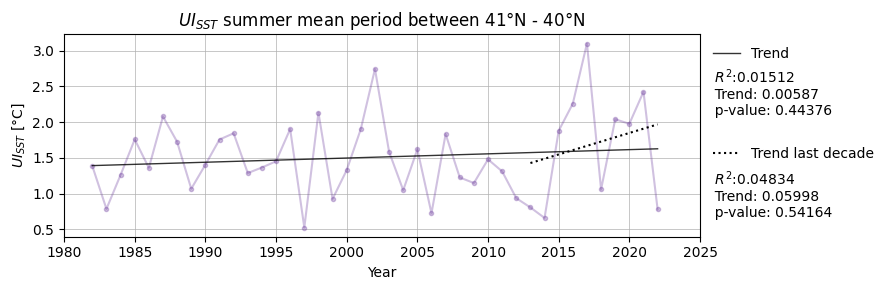

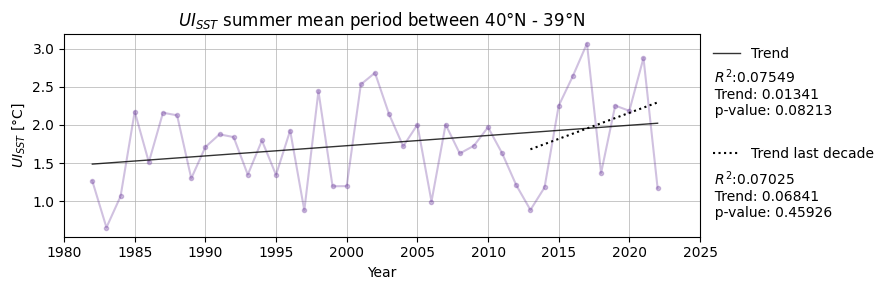

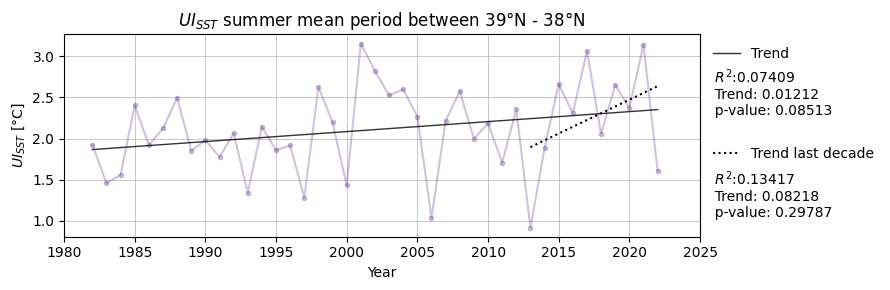

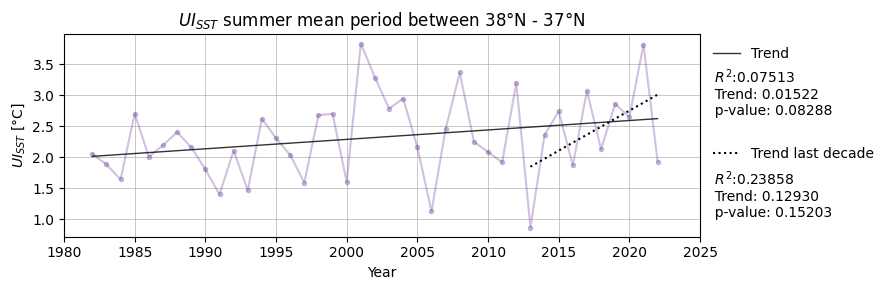

In [31]:
## the summer UI SST for every degree lat (mean around that latitude)
for lats in np.arange(44, 37, -1): # from 44°N coast has more of a SE-NW direction
    y = SST_summer_mean.UI.sel(lon = -15, method = 'nearest').sel(lat = slice(lats-1, lats)).mean(dim = 'lat')
    plot_trend(SST_summer_mean.time, y, col = 'rebeccapurple', #'mediumvioletred', 
               title = (r'$UI_{SST}$ summer mean period' f' between {lats}°N - {lats - 1}°N'), ylabel = r'$UI_{SST}$ [°C]',
               save = save_var, save_fig_as = f'UI_SST_summer_seasonal_mean_{lats}_to_{lats - 1}') 

### UI<sub>SST</sub> Anomaly

Summer mean SST (from summer annual mean) 2.05
Summer mean SST (from all summer weeks) 2.05


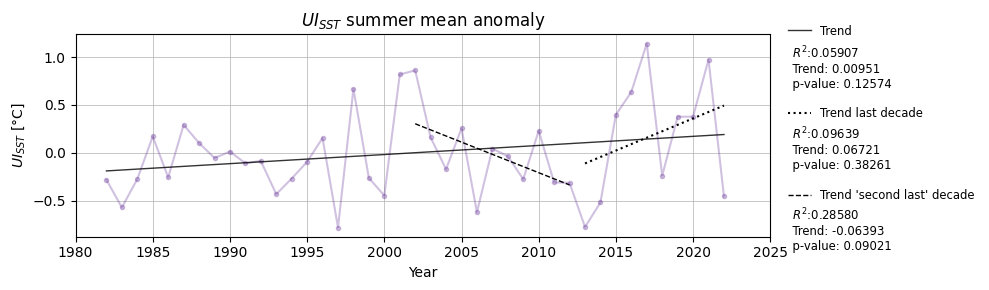

In [158]:
SST_anomaly = SST_summer_mean.UI_mean - SST_summer_mean.UI_mean.mean(dim = 'time')
print('Summer mean SST (from summer annual mean)', np.round(SST_summer_mean.UI_mean.mean(dim = 'time').values, 3))
print('Summer mean SST (from all summer weeks)', np.round(SST_summer.UI_mean.mean(dim = 'time').values, 3))
plot_trend_2(SST_summer_mean.time, SST_anomaly, col = 'rebeccapurple', 
           title = r'$UI_{SST}$ summer mean anomaly', ylabel = r'$UI_{SST}$ [°C]'
             , save = save_var, save_fig_as = 'UI_SST_summer_anomaly_trends')

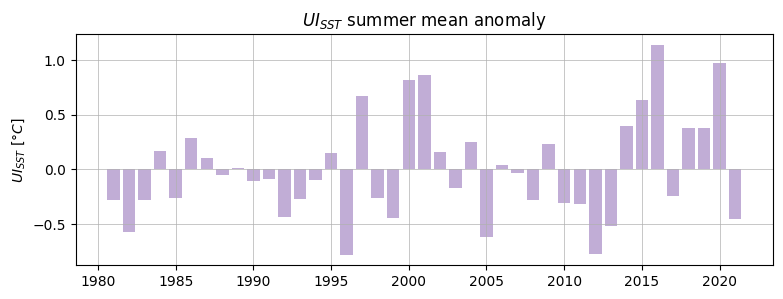

In [157]:
# same data as above but bar plot for visualisation (common for anomaly visualisation??) 
fig = plt.figure(figsize = (9,3))
plt.bar(SST_anomaly.time.dt.year, SST_anomaly.values, color = 'rebeccapurple', alpha = 0.4)
plt.title(r'$UI_{SST}$ summer mean anomaly')
plt.ylabel(r'$UI_{SST} \ [°C]$')
plt.grid(lw = 0.5)
plt.savefig('UI_SST_summer_mean_anomaly.png', dpi = 300, bbox_inches = 'tight')

## **ERA5 UI<sub>SST</sub> and UI<sub>Ek</sub> Extended Data _______________________________________________________________________________________________________________**

In [218]:
# UI Ek and ERA5 SST over the whole period
MTSS_all = xr.open_dataset('/Users/marie-louisekorte/Documents/Uni Leipzig/Lisbon/Data.nosync/MTSS_all_weekly.nc')
ERA5_SST = xr.open_dataset('/Users/marie-louisekorte/Documents/Uni Leipzig/Lisbon/Data.nosync/ERA5_SST_weekly.nc')

In [198]:
Ek_all = MTSS_all
Ek_all = my_functions.calc_upwelling_index(MTSS_all, MTSS_all.lat, MTSS_all.lon, MTSS_all.metss.where(MTSS_all.lsm), MTSS_all.mntss.where(MTSS_all.lsm),
                                       near_shore = True, angles = Angles.angle_phi)
Ek_all = my_functions.add_mid_shelf(Ek_all, mid_shelf_lat, mid_shelf_lon)

# UI SST and SSH
ERA5_SST = my_functions.add_mid_shelf(ERA5_SST, mid_shelf_lat, mid_shelf_lon)
ERA5_SST['UI'] = ERA5_SST.SST.where(ERA5_SST.lon == -15) - ERA5_SST.SST.where(ERA5_SST.mid_shelf).mean(dim = 'lon')
ERA5_SST.UI.attrs.update({'Name' : 'SST upwelling index', 'Info' : 'SST at 15° - SST at mid-shelf', 'Sign' : 'positive inidcates upwelling'})

In [201]:
Ek_all = my_functions.calc_meridional_mean(Ek_all, lon = -10.5)
ERA5_SST = my_functions.calc_meridional_mean(ERA5_SST, lon = -15)

In [202]:
Ek_all_summer = my_functions.subset_summer(Ek_all)
ERA5_SST_summer = my_functions.subset_summer(ERA5_SST)

In [205]:
# create Ek_ns dataset with meridional mean and summer subset
Ek_all_ns = Ek_all
Ek_all_ns = Ek_all_ns.drop_vars(["UI", "UI_mean"])
Ek_all_ns['UI'] = Ek_all_ns.UI_ns 
UI_mean = Ek_all_ns.UI.mean(dim = ['lat', 'lon'])
Ek_all_ns['UI_mean'] = UI_mean
Ek_all_ns_summer = my_functions.subset_summer(Ek_all_ns)

In [293]:
Ek_all_summer_mean = Ek_all_summer.resample(time = 'YE', label = 'left').mean(dim = 'time') # label is assigned to start of year
Ek_all_ns_summer_mean = Ek_all_ns_summer.resample(time = 'YE', label = 'left').mean(dim = 'time') # label is assigned to start of year
ERA5_SST_summer_mean = ERA5_SST_summer.resample(time = 'YE', label = 'left').mean(dim = 'time') # label is assigned to start of year

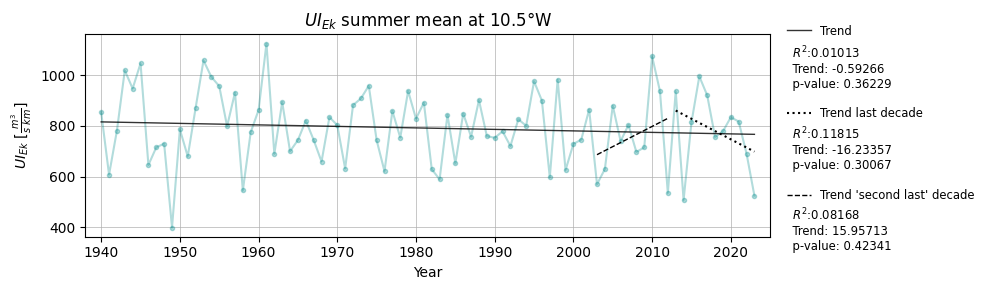

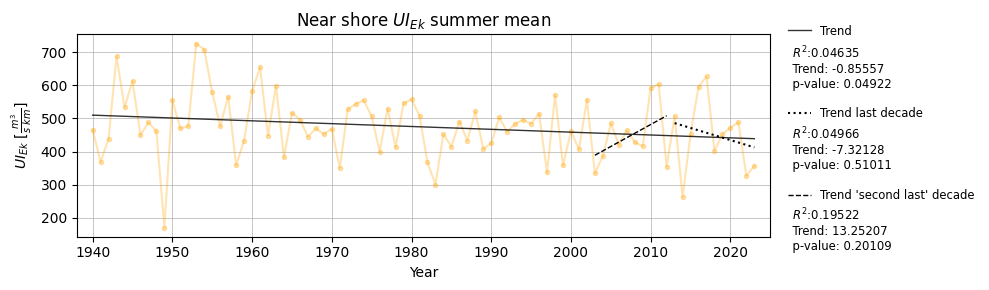

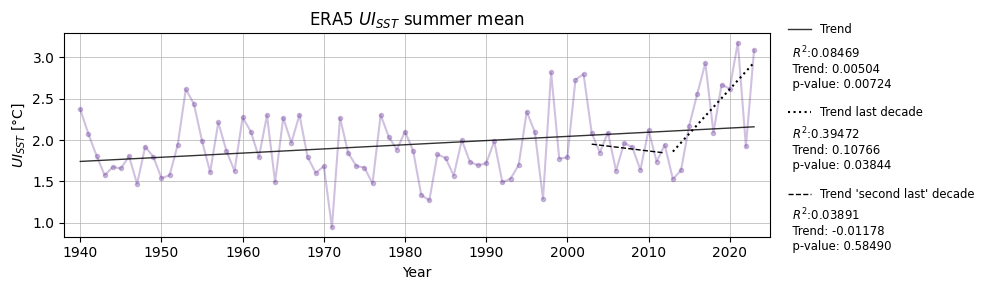

In [379]:
plot_trend_2(Ek_all_summer_mean.time, Ek_all_summer_mean.UI_mean * 1000, title = r'$UI_{Ek}$ summer mean at 10.5°W', 
           ylabel = r'$UI_{Ek} \ [\frac{m^3}{s \ km}]$', save = save_var, save_fig_as = 'UI_Ek_all_summer_seasonal_mean', long = True)
plot_trend_2(Ek_all_ns_summer_mean.time, Ek_all_ns_summer_mean.UI_mean * 1000, title = r'Near shore $UI_{Ek}$ summer mean', 
           col = 'orange', ylabel = r'$UI_{Ek} \ [\frac{m^3}{s \ km}]$', save = save_var, save_fig_as = 'UI_Ek_all_ns_summer_seasonal_mean', long = True)
plot_trend_2(ERA5_SST_summer_mean.time, ERA5_SST_summer_mean.UI_mean, col = 'rebeccapurple', title = r'ERA5 $UI_{SST}$ summer mean', 
           ylabel = r'$UI_{SST}$ [°C]', save = save_var, save_fig_as = 'UI_SST_ERA5_summer_seasonal_mean_2', long = True)

In [303]:
ERA5_SST_15_off = ERA5_SST_summer_mean #.where(ERA5_SST_summer.lon == -15))
ERA5_SST_15_off = my_functions.calc_meridional_mean(ERA5_SST_15_off , variable = 'SST', lon = -15)
ERA5_SST_mid_shelf = ERA5_SST_summer_mean
ERA5_SST_mid_shelf = ERA5_SST_mid_shelf.where(ERA5_SST_summer_mean.mid_shelf).SST.mean(dim = ['lat', 'lon'])

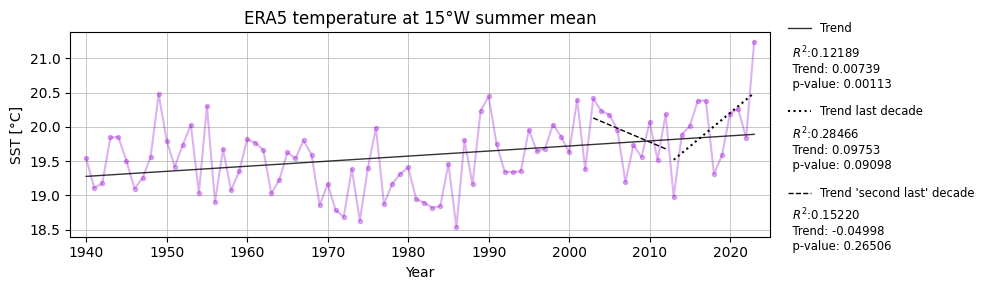

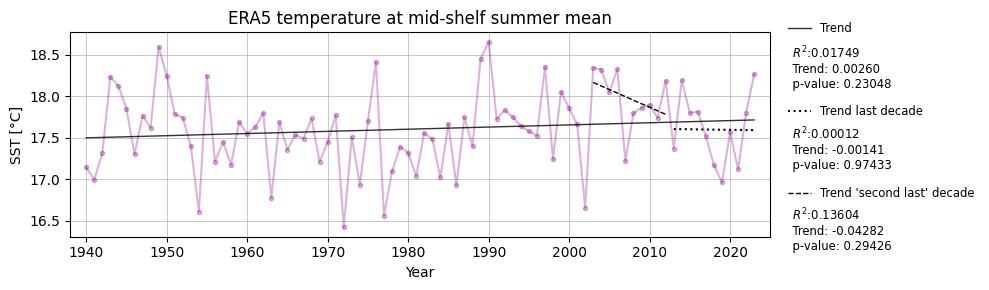

In [304]:
plot_trend_2(ERA5_SST_15_off.time, ERA5_SST_15_off.SST_mean, col = 'darkviolet', title = r'ERA5 temperature at 15°W summer mean', 
           ylabel = r'SST [°C]', save = save_var, save_fig_as = 'SST_ERA5_15_summer_seasonal_mean', long = True)
plot_trend_2(ERA5_SST_mid_shelf.time, ERA5_SST_mid_shelf, col = 'darkmagenta', title = r'ERA5 temperature at mid-shelf summer mean', 
           ylabel = r'SST [°C]', save = save_var, save_fig_as = 'SST_ERA5_mid_shelf_summer_seasonal_mean', long = True)

In [358]:
# substract the mean T trend over the whole area first
SST_mean_trend = ERA5_SST_summer_mean.SST.mean(dim = ['lat', 'lon'])
regress = linregress(np.arange(len(SST_mean_trend)), SST_mean_trend)
SST_trend = np.arange(len(SST_mean_trend)) * regress.slope

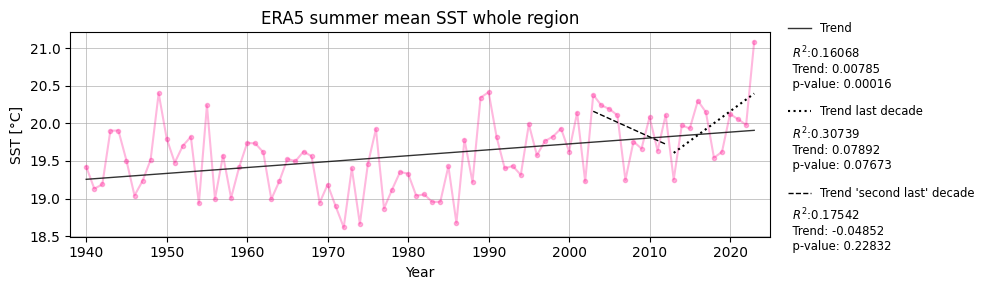

In [336]:
plot_trend_2(SST_mean_trend.time, SST_mean_trend, col = 'deeppink', title = r'ERA5 summer mean SST whole region', 
           ylabel = r'SST [°C]', save = save_var, save_fig_as = 'SST_ERA5_regional_seasonal_mean', long = True)

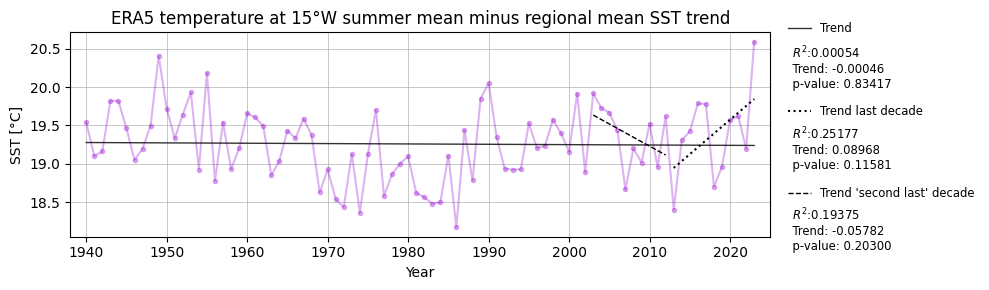

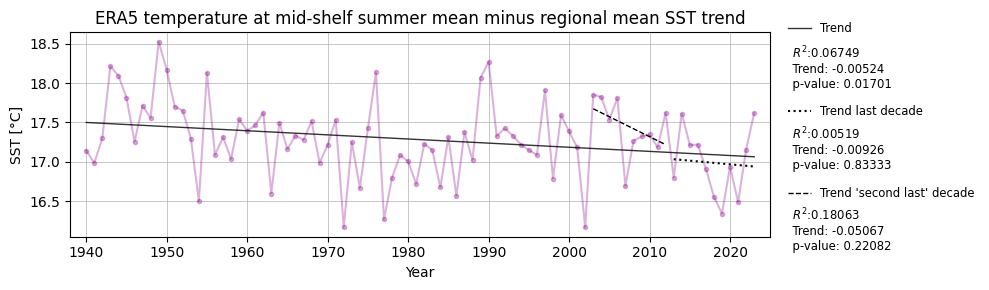

In [360]:
plot_trend_2(ERA5_SST_15_off.time, ERA5_SST_15_off.SST_mean - SST_trend, col = 'darkviolet', title = r'ERA5 temperature at 15°W summer mean minus regional mean SST trend', 
           ylabel = r'SST [°C]', save = save_var, save_fig_as = 'SST_ERA5_15_summer_seasonal_mean', long = True)
plot_trend_2(ERA5_SST_mid_shelf.time, ERA5_SST_mid_shelf - SST_trend, col = 'darkmagenta', title = r'ERA5 temperature at mid-shelf summer mean minus regional mean SST trend', 
           ylabel = r'SST [°C]', save = save_var, save_fig_as = 'SST_ERA5_mid_shelf_summer_seasonal_mean', long = True)

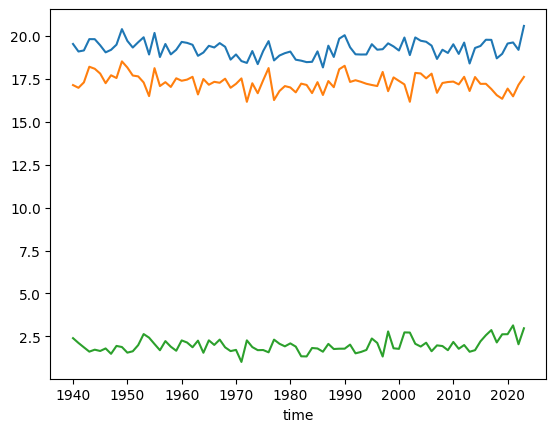

In [415]:
bla1 = ERA5_SST_15_off.SST_mean - SST_trend
bla2 = ERA5_SST_mid_shelf - SST_trend
bla1.plot()
bla2.plot()
(bla1 - bla2).plot()

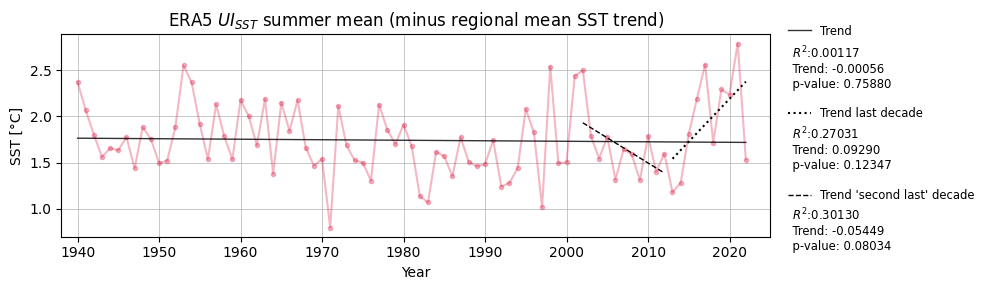

In [428]:
# get the trend in UI_SST after removing regional T trend (this is to make sure that any remaining trend is due to regional differences (not overall warming trend) 
    # -> trends are still diverging... because removing mean T trend does not remove overall tendancy of mid-shelf to decrease less in T than 15°W
UI_SST_trend = (ERA5_SST_15_off.SST_mean - SST_trend) - (ERA5_SST_mid_shelf - SST_trend) # (T 15°W - trend) - (T mid-shelf - trend)

# calculate the T trend in the UI_SST calculated after removing regional T trend
regress = linregress(np.arange(len(ERA5_SST_mid_shelf.time)), UI_SST_trend)
UI_SST_trend_line = np.arange(len(ERA5_SST_mid_shelf.time)) * regress.slope

# now remove the trend in UI_SST due to regional difference in T trends to get a new UI_SST that just show the trend in UI_SST whith removed influence of different rates of warming in the regions
    # is pretty variable, no significant trend sign changes if we remove 2023 data (.isel(time = slice(0, -1)))
UI_SST_minus_trend = ERA5_SST_summer_mean.UI_mean - UI_SST_trend_line
plot_trend_2(ERA5_SST_mid_shelf.time, UI_SST_minus_trend, col = 'crimson', title = r'ERA5 $UI_{SST}$ summer mean (minus regional mean SST trend)', 
           ylabel = r'SST [°C]', save = save_var, save_fig_as = 'UI_SST_minus_regional_trend', long = True)
# is this an appropirate way to deal with my data??

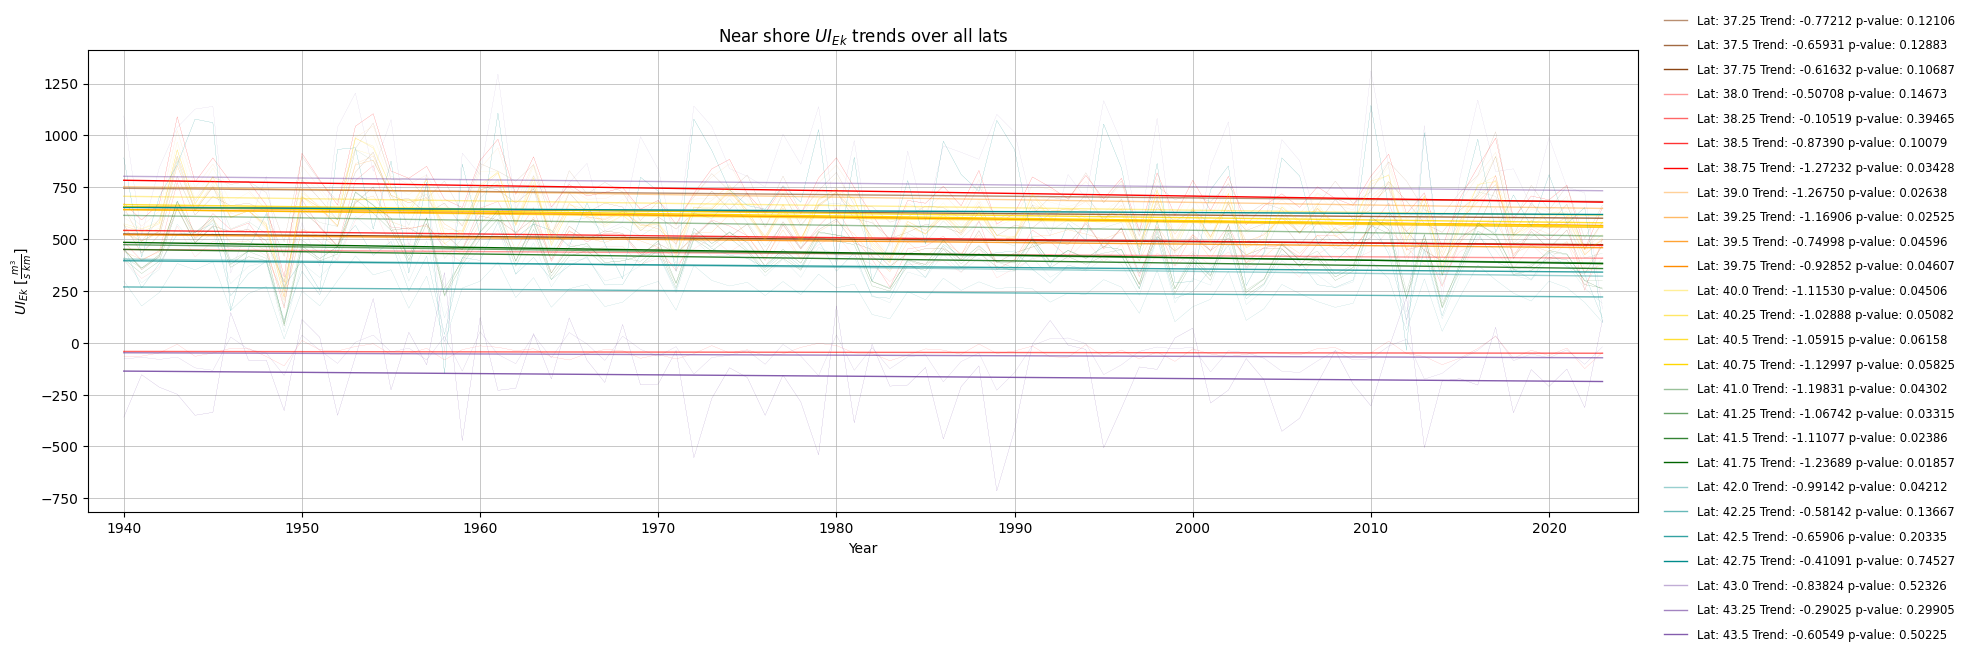

In [403]:
x_dates = Ek_all_ns_summer_mean.time
x = np.arange(len(x_dates))
plt.figure(figsize = (20, 6))
col = ['saddlebrown', 'saddlebrown', 'saddlebrown', 'red', 'red', 'red', 'red', 'darkorange', 'darkorange', 'darkorange', 'darkorange', 'gold', 'gold', 'gold', 'gold', 
       'darkgreen', 'darkgreen', 'darkgreen', 'darkgreen',
       'darkcyan', 'darkcyan', 'darkcyan', 'darkcyan', 'rebeccapurple', 'rebeccapurple', 'rebeccapurple', 'rebeccapurple']
alpha = [0.6, 0.8, 1, 0.4, 0.6, 0.8, 1, 0.4, 0.6, 0.8, 1, 0.4, 0.6, 0.8, 1, 0.4, 0.6, 0.8, 1, 0.4, 0.6, 0.8, 1, 0.4, 0.6, 0.8, 1,]

for lat, i in zip(np.arange(37.25, 43.75, 0.25), np.arange(0,len(col))):
    #Ek_all.nsm.where((Ek_all.lat >= 37.25) & (Ek_all.lat <= 43.5)).plot()
    summer_mean = Ek_all_ns_summer.UI.sel(lat = lat).resample(time = 'YE', label = 'left').mean(dim = ['time', 'lon']) # label is assigned to start of year
    
    # get regression of trend
    y = summer_mean.values * 1000
    regression = linregress(x, y)
    # text for label 
    label = (f'Lat: {lat} Trend: {regression.slope:.5f} p-value: {regression.pvalue:.5f}')
    # trend whole period
    plt.plot(x_dates, summer_mean * 1000, color = col[i], alpha = alpha[i], lw = 0.1)
    plt.plot(x_dates, x*regression.slope + regression.intercept, color = col[i], alpha = alpha[i], lw = 1, label = label) 

    plt.legend(bbox_to_anchor=(1.01, 1.1), loc = 'upper left', labelspacing = 1, edgecolor = 'none', facecolor = 'none', fontsize = 'small')
    plt.title(r'Near shore $UI_{Ek}$ trends over all lats')
    plt.xlabel('Year')
    plt.ylabel(r'$UI_{Ek} \ [\frac{m^3}{s \ km}]$')
    plt.xlim(dates.date2num(['1938']), dates.date2num(['2025']))
    plt.grid(lw = 0.5)

# 43.25, 43.5 and 38.25 were have downwelling (negative UI_Ek) but still show a negative trend... so that means the downwelling is intensifying right?
    # decreasing UI_Ek means a weaker off-shore transport i.e. in this case since we already have negative off-shore transport (i.e. onshore transport) -> that is intensifying

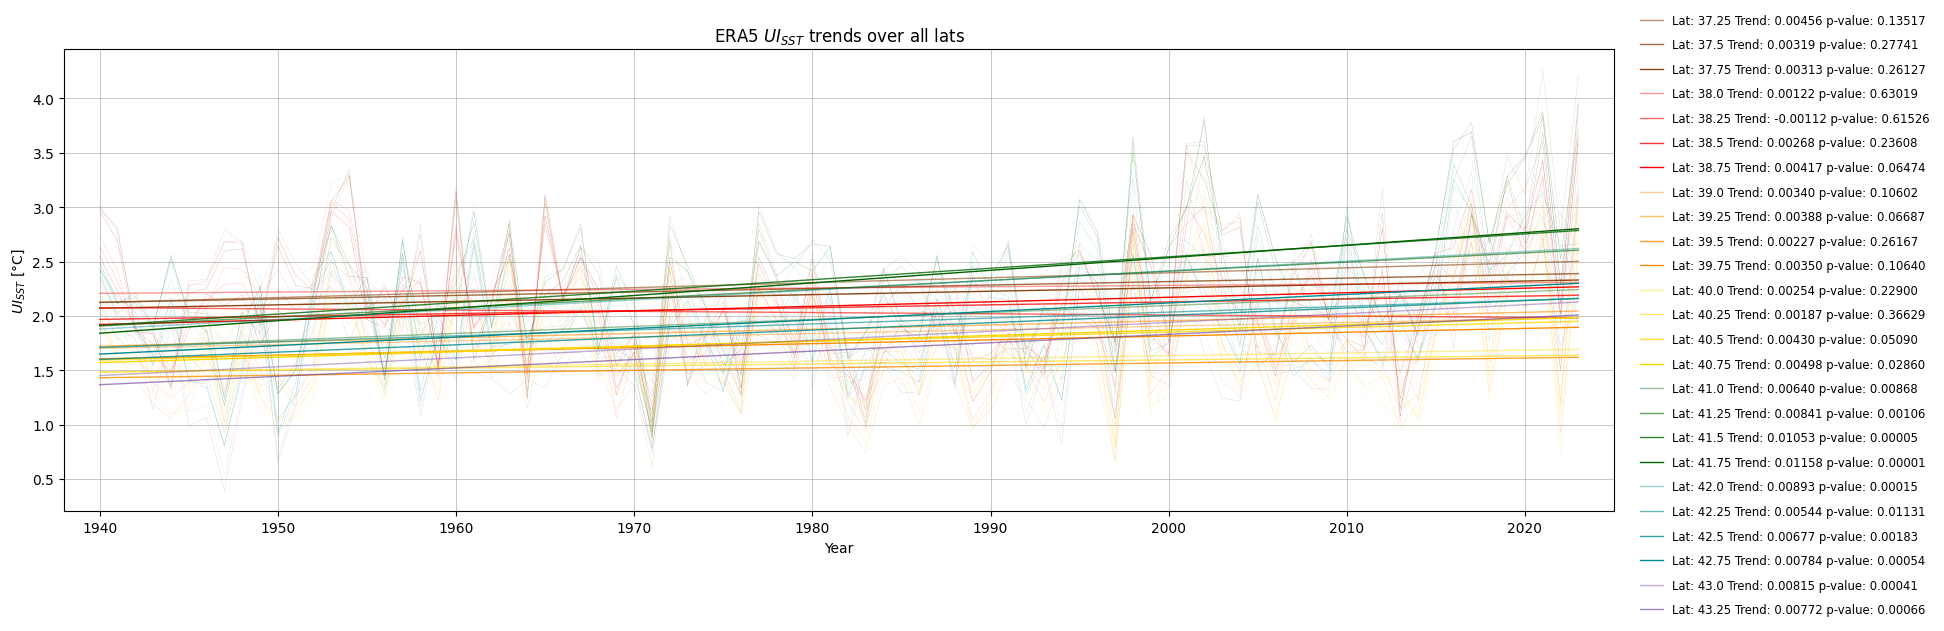

In [367]:
x_dates = ERA5_SST_summer_mean.time
x = np.arange(len(x_dates))
plt.figure(figsize = (20, 6))
col = ['saddlebrown', 'saddlebrown', 'saddlebrown', 'red', 'red', 'red', 'red', 'darkorange', 'darkorange', 'darkorange', 'darkorange', 'gold', 'gold', 'gold', 'gold', 
       'darkgreen', 'darkgreen', 'darkgreen', 'darkgreen',
       'darkcyan', 'darkcyan', 'darkcyan', 'darkcyan', 'rebeccapurple', 'rebeccapurple', 'rebeccapurple', 'rebeccapurple']
alpha = [0.6, 0.8, 1, 0.4, 0.6, 0.8, 1, 0.4, 0.6, 0.8, 1, 0.4, 0.6, 0.8, 1, 0.4, 0.6, 0.8, 1, 0.4, 0.6, 0.8, 1, 0.4, 0.6, 0.8, 1,]

for lat, i in zip(np.arange(37.25, 43.5, 0.25), np.arange(0,len(col))):
    summer_mean = ERA5_SST_summer.UI.sel(lat = lat).resample(time = 'YE', label = 'left').mean(dim = ['time', 'lon']) #- SST_trend# label is assigned to start of year
    
    # get regression of trend
    y = summer_mean.values
    regression = linregress(x, y)
    # text for label 
    label = (f'Lat: {lat} Trend: {regression.slope:.5f} p-value: {regression.pvalue:.5f}')
    # trend whole period
    plt.plot(x_dates, summer_mean, color = col[i], alpha = alpha[i], lw = 0.1)
    plt.plot(x_dates, x*regression.slope + regression.intercept, color = col[i], alpha = alpha[i], lw = 1, label = label) 

    plt.legend(bbox_to_anchor=(1.01, 1.1), loc = 'upper left', labelspacing = 1, edgecolor = 'none', facecolor = 'none', fontsize = 'small')
    plt.title(r'ERA5 $UI_{SST}$ trends over all lats') # (minus regional mean trend)')
    plt.xlabel('Year')
    plt.ylabel(r'$UI_{SST}$ [°C]')
    plt.xlim(dates.date2num(['1938']), dates.date2num(['2025']))
    plt.grid(lw = 0.5)

Lat: 37.25 correlation: 0.330 p-value = 0.002
Lat: 37.5 correlation: 0.329 p-value = 0.002
Lat: 37.75 correlation: 0.354 p-value = 0.001
Lat: 38.0 correlation: 0.352 p-value = 0.001
Lat: 38.25 correlation: 0.226 p-value = 0.038
Lat: 38.5 correlation: 0.426 p-value = 0.000
Lat: 38.75 correlation: 0.323 p-value = 0.003
Lat: 39.0 correlation: 0.336 p-value = 0.002
Lat: 39.25 correlation: 0.271 p-value = 0.013
Lat: 39.5 correlation: 0.340 p-value = 0.002
Lat: 39.75 correlation: 0.372 p-value = 0.001
Lat: 40.0 correlation: 0.424 p-value = 0.000
Lat: 40.25 correlation: 0.412 p-value = 0.000
Lat: 40.5 correlation: 0.385 p-value = 0.000
Lat: 40.75 correlation: 0.397 p-value = 0.000
Lat: 41.0 correlation: 0.394 p-value = 0.000
Lat: 41.25 correlation: 0.378 p-value = 0.000
Lat: 41.5 correlation: 0.340 p-value = 0.002
Lat: 41.75 correlation: 0.283 p-value = 0.009
Lat: 42.0 correlation: 0.324 p-value = 0.003
Lat: 42.25 correlation: 0.431 p-value = 0.000
Lat: 42.5 correlation: 0.426 p-value = 0.000

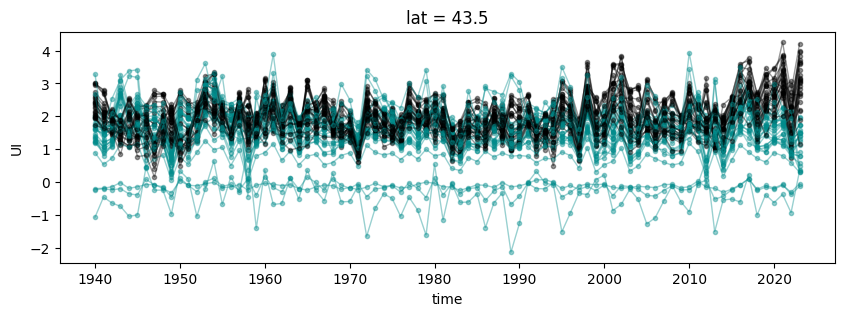

In [399]:
plt.figure(figsize =(10,3))
for lat, i in zip(np.arange(37.25, 43.75, 0.25), np.arange(0,len(col))):
    Ek_ns_sub = Ek_all_ns_summer_mean.UI.sel(lat = lat).mean(dim = 'lon') # label is assigned to start of year
    ERA5_SST_sub = ERA5_SST_summer_mean.UI.sel(lat = lat).mean(dim = 'lon')

    result = pearsonr(Ek_ns_sub, ERA5_SST_sub)
    
    (ERA5_SST_sub).plot(color = 'k', lw = 1, marker = '.', alpha = 0.4)
    (Ek_ns_sub * 3).plot(color = 'darkcyan', lw = 1, marker = '.', alpha = 0.4)
    print(f'Lat: {lat} correlation: {result[0]:.3f} p-value = {result[1]:.3f}')

Lat: 37.25 correlation: 0.381 p-value = 0.000
Lat: 37.5 correlation: 0.375 p-value = 0.000
Lat: 37.75 correlation: 0.405 p-value = 0.000
Lat: 38.0 correlation: 0.391 p-value = 0.000
Lat: 38.25 correlation: 0.241 p-value = 0.027
Lat: 38.5 correlation: 0.484 p-value = 0.000
Lat: 38.75 correlation: 0.413 p-value = 0.000
Lat: 39.0 correlation: 0.430 p-value = 0.000
Lat: 39.25 correlation: 0.370 p-value = 0.001
Lat: 39.5 correlation: 0.417 p-value = 0.000
Lat: 39.75 correlation: 0.455 p-value = 0.000
Lat: 40.0 correlation: 0.500 p-value = 0.000
Lat: 40.25 correlation: 0.480 p-value = 0.000
Lat: 40.5 correlation: 0.469 p-value = 0.000
Lat: 40.75 correlation: 0.485 p-value = 0.000
Lat: 41.0 correlation: 0.491 p-value = 0.000
Lat: 41.25 correlation: 0.484 p-value = 0.000
Lat: 41.5 correlation: 0.460 p-value = 0.000
Lat: 41.75 correlation: 0.407 p-value = 0.000
Lat: 42.0 correlation: 0.439 p-value = 0.000
Lat: 42.25 correlation: 0.512 p-value = 0.000
Lat: 42.5 correlation: 0.509 p-value = 0.000

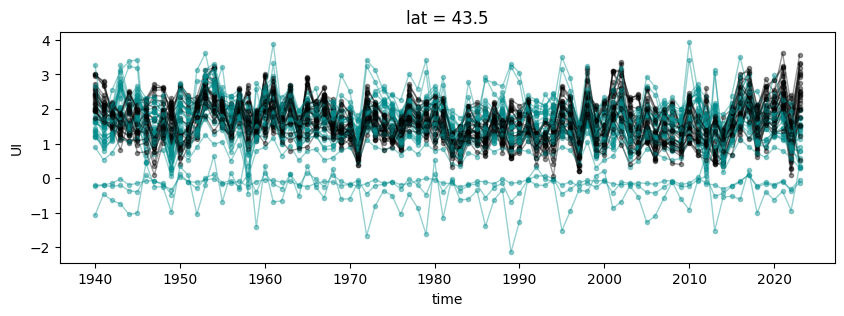

In [401]:
plt.figure(figsize =(10,3))
for lat, i in zip(np.arange(37.25, 43.75, 0.25), np.arange(0,len(col))):
    Ek_ns_sub = Ek_all_ns_summer_mean.UI.sel(lat = lat).mean(dim = 'lon') # label is assigned to start of year
    ERA5_SST_sub = ERA5_SST_summer_mean.UI.sel(lat = lat).mean(dim = 'lon') - SST_trend

    result = pearsonr(Ek_ns_sub, ERA5_SST_sub)

    (ERA5_SST_sub).plot(color = 'k', lw = 1, marker = '.', alpha = 0.4)
    (Ek_ns_sub * 3).plot(color = 'darkcyan', lw = 1, marker = '.', alpha = 0.4)
    print(f'Lat: {lat} correlation: {result[0]:.3f} p-value = {result[1]:.3f}')

Lat: 37.25 correlation: -0.303 p-value = 0.005
Lat: 37.5 correlation: -0.300 p-value = 0.006
Lat: 37.75 correlation: -0.356 p-value = 0.001
Lat: 38.0 correlation: -0.388 p-value = 0.000
Lat: 38.25 correlation: -0.229 p-value = 0.037
Lat: 38.5 correlation: -0.433 p-value = 0.000
Lat: 38.75 correlation: -0.363 p-value = 0.001
Lat: 39.0 correlation: -0.383 p-value = 0.000
Lat: 39.25 correlation: -0.384 p-value = 0.000
Lat: 39.5 correlation: -0.478 p-value = 0.000
Lat: 39.75 correlation: -0.429 p-value = 0.000
Lat: 40.0 correlation: -0.402 p-value = 0.000
Lat: 40.25 correlation: -0.404 p-value = 0.000
Lat: 40.5 correlation: -0.386 p-value = 0.000
Lat: 40.75 correlation: -0.385 p-value = 0.000
Lat: 41.0 correlation: -0.387 p-value = 0.000
Lat: 41.25 correlation: -0.389 p-value = 0.000
Lat: 41.5 correlation: -0.376 p-value = 0.000
Lat: 41.75 correlation: -0.343 p-value = 0.001
Lat: 42.0 correlation: -0.363 p-value = 0.001
Lat: 42.25 correlation: -0.403 p-value = 0.000
Lat: 42.5 correlation: 

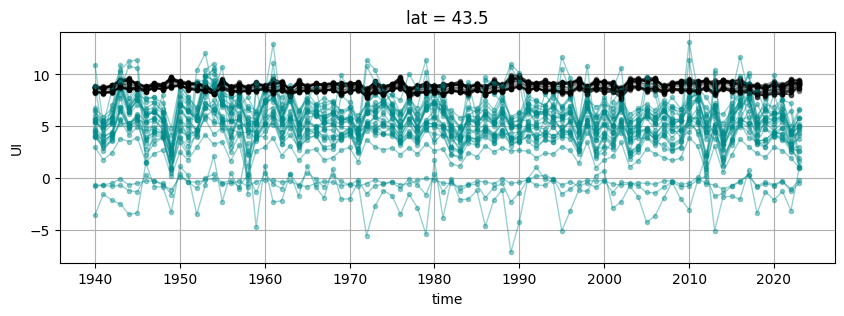

In [400]:
plt.figure(figsize =(10,3))
for lat, i in zip(np.arange(37.25, 43.75, 0.25), np.arange(0,len(col))):
    Ek_ns_sub = Ek_all_ns_summer_mean.UI.sel(lat = lat).mean(dim = 'lon') # label is assigned to start of year
    ERA5_SST_sub = ERA5_SST_summer_mean.SST.where(ERA5_SST_summer_mean.mid_shelf).sel(lat = lat).mean(dim = 'lon')

    result = pearsonr(Ek_ns_sub, ERA5_SST_sub)
    (ERA5_SST_sub * 0.5).plot(color = 'k', lw = 1, marker = '.', alpha = 0.4)
    (Ek_ns_sub * 10).plot(color = 'darkcyan', lw = 1, marker = '.', alpha = 0.4)
    print(f'Lat: {lat} correlation: {result[0]:.3f} p-value = {result[1]:.3f}')
plt.grid()

## UI<sub>SSH</sub>  _______________________________________________________________________________________________________________**

### UI<sub>SSH</sub> Trend

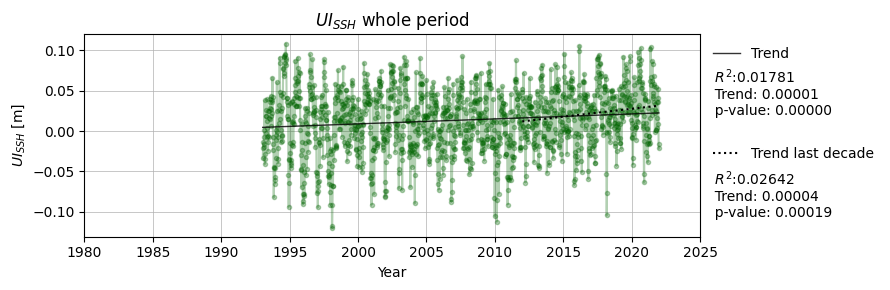

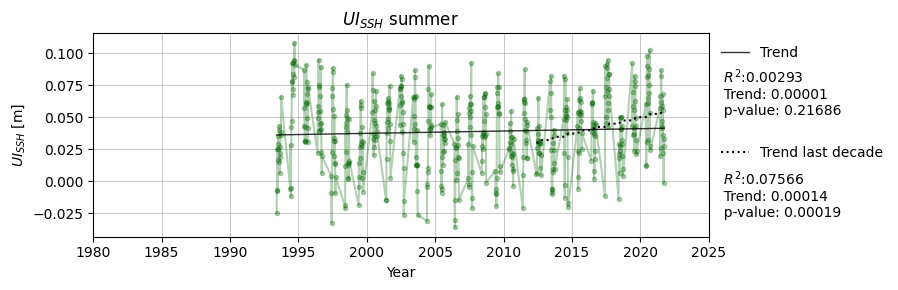

In [33]:
plot_trend(SSH.time, SSH.UI_mean, col = 'darkgreen',
           title = r'$UI_{SSH}$ whole period', ylabel = r'$UI_{SSH}$ [m]')
plot_trend(SSH_summer.time, SSH_summer.UI_mean, col = 'darkgreen',
           title = r'$UI_{SSH}$ summer', ylabel = r'$UI_{SSH}$ [m]',
           save = save_var, save_fig_as = 'UI_SSH_summer_all')

### UI<sub>SSH</sub> Seasonal mean and anomalies

In [34]:
# calculate the mean over the summer months
SSH_summer_mean = SSH_summer.resample(time = 'YE', label = 'left').mean(dim = 'time') # label is assigned to start of year

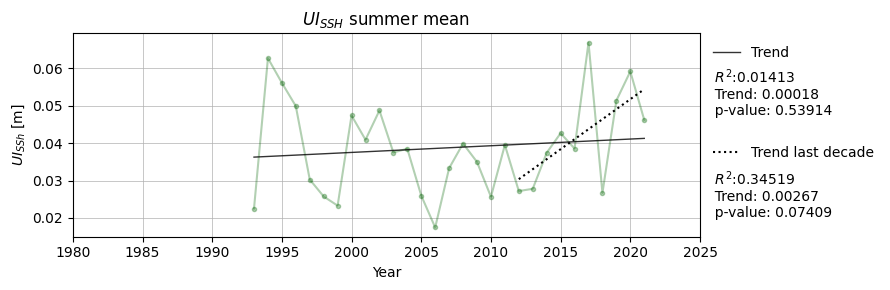

In [35]:
plot_trend(SSH_summer_mean.time, SSH_summer_mean.UI_mean, col = 'darkgreen', title = r'$UI_{SSH}$ summer mean', 
           ylabel = r'$UI_{SSh}$ [m]', save = save_var, save_fig_as = 'UI_SSH_summer_seasnoal_mean')

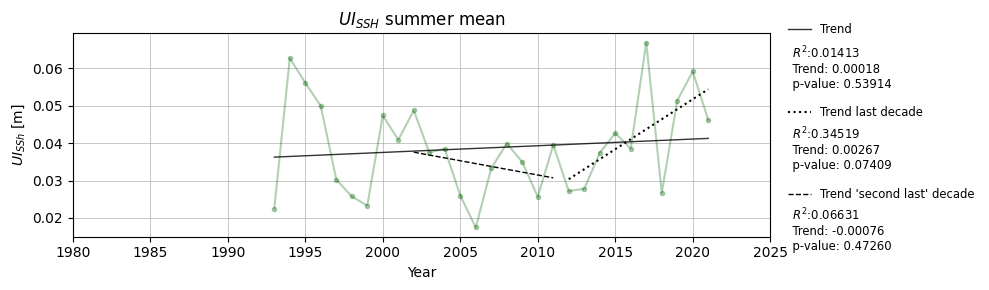

In [36]:
plot_trend_2(SSH_summer_mean.time, SSH_summer_mean.UI_mean, col = 'darkgreen', title = r'$UI_{SSH}$ summer mean', 
           ylabel = r'$UI_{SSh}$ [m]', save = save_var, save_fig_as = 'UI_SSH_summer_seasnoal_mean_2')

#### UI<sub>SSH</sub> at different lats

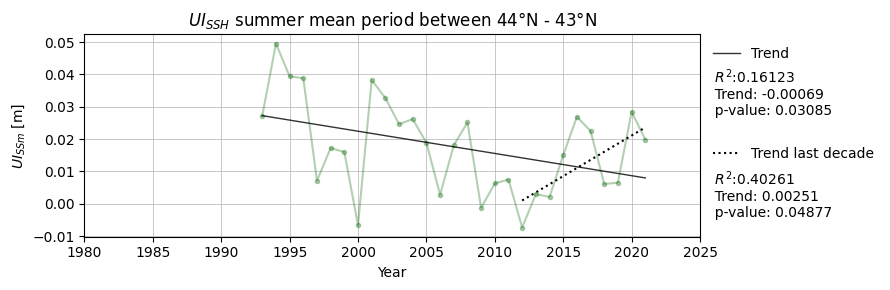

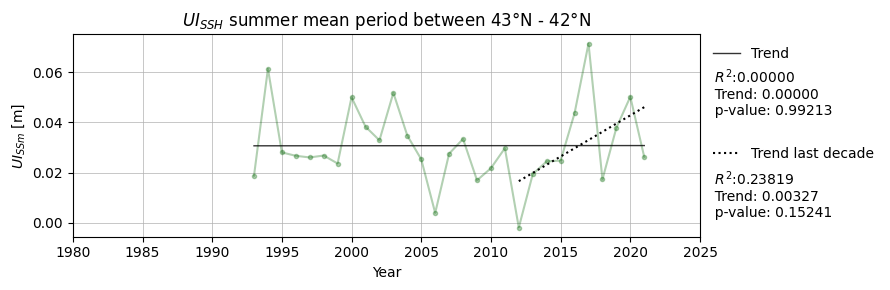

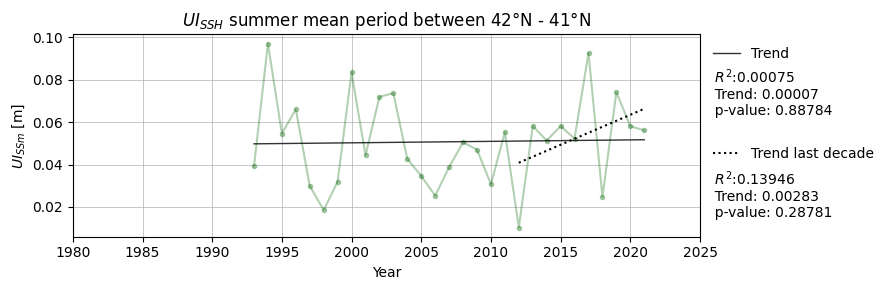

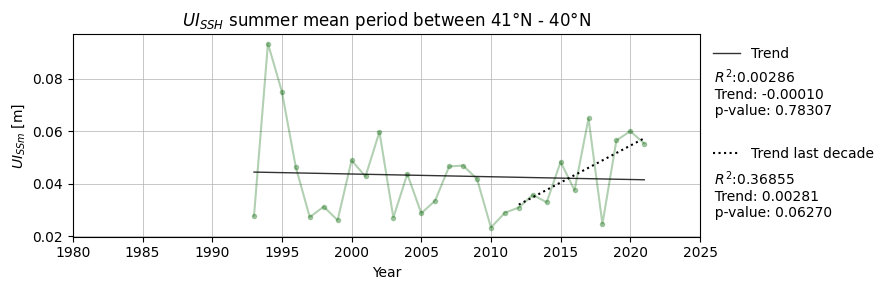

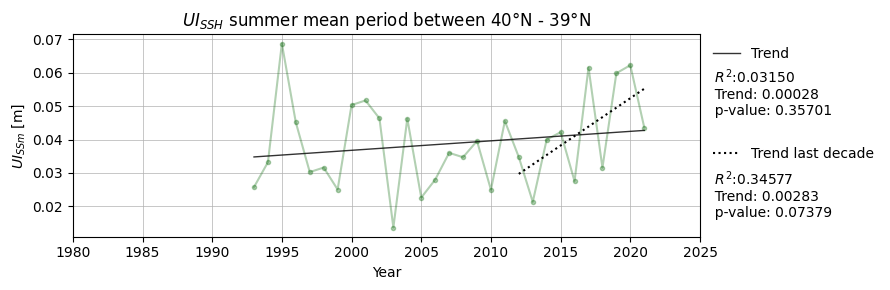

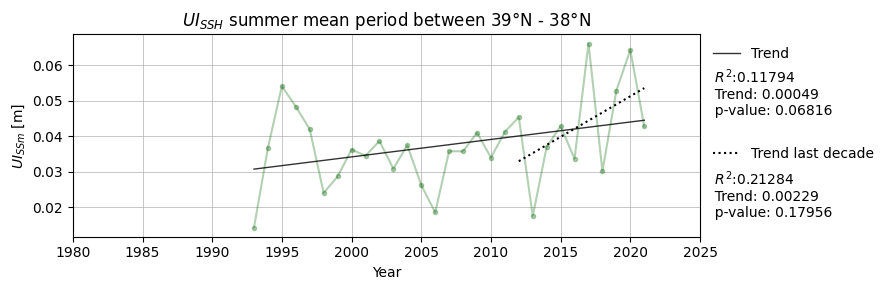

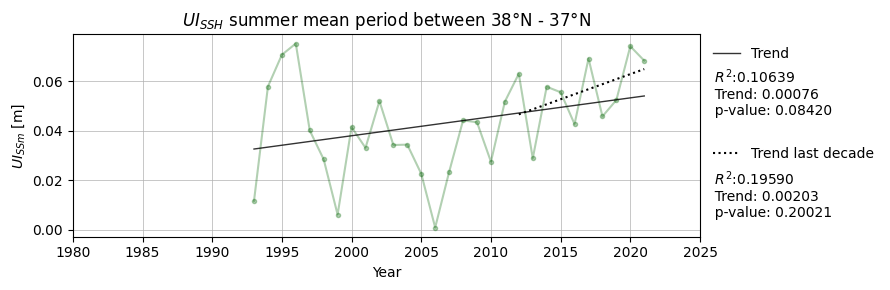

In [37]:
## the summer UI SST for every degree lat (mean around that latitude)
for lats in np.arange(44, 37, -1): # from 44°N coast has more of a SE-NW direction
    y = SSH_summer_mean.UI.sel(lon = -10.5, method = 'nearest').sel(lat = slice(lats-1, lats)).mean(dim = 'lat')
    plot_trend(SSH_summer_mean.time, y, col = 'darkgreen', 
               title = (r'$UI_{SSH}$ summer mean period' f' between {lats}°N - {lats - 1}°N'), ylabel = r'$UI_{SSm}$ [m]',
               save = save_var, save_fig_as = f'UI_SSH_summer_seasonal_mean_{lats}_to_{lats - 1}') 

Summer mean UI SSH 0.039


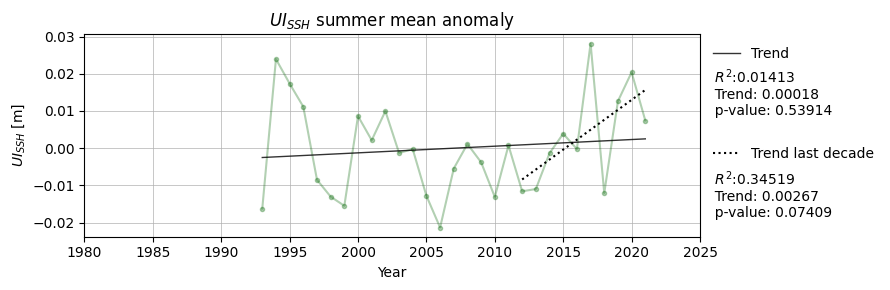

In [38]:
SSH_anomaly = SSH_summer_mean.UI_mean - SSH_summer_mean.UI_mean.mean(dim = 'time')
print('Summer mean UI SSH', np.round(SSH_summer_mean.UI_mean.mean(dim = 'time').values, 3))
plot_trend(SSH_summer_mean.time, SSH_anomaly, col = 'darkgreen',
           title = r'$UI_{SSH}$ summer mean anomaly', ylabel = r'$UI_{SSH}$ [m]')

## Other

Text(0, 0.5, 'UI SST [°C]')

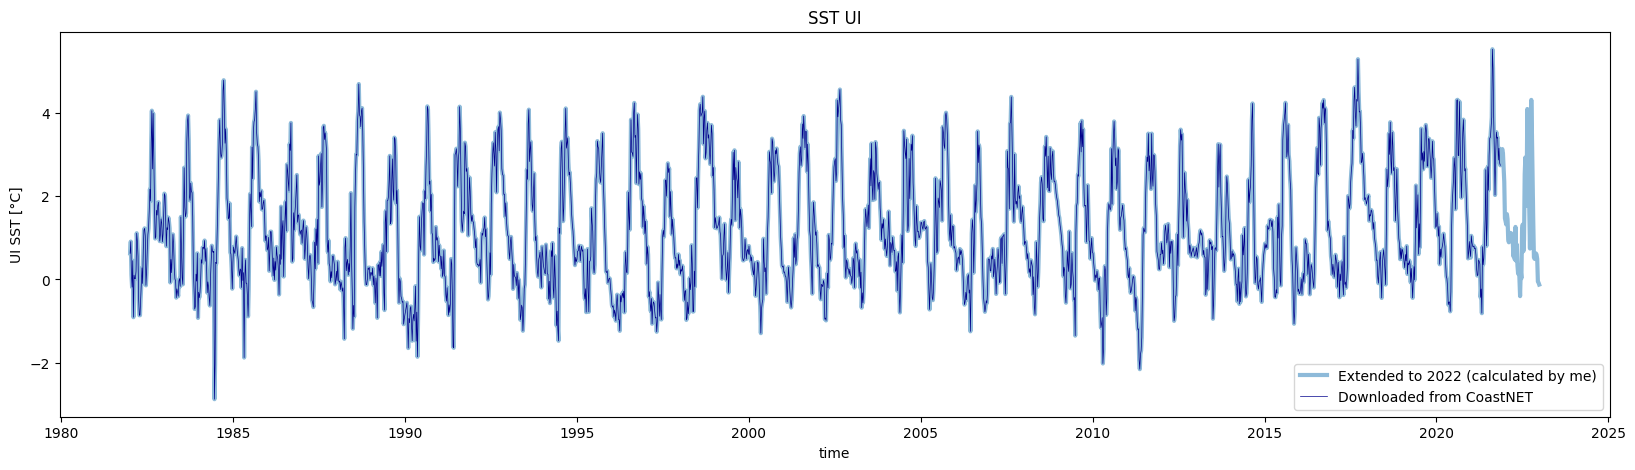

In [39]:
## compare UI SST from CoastNET with self calculated UI SST with cortadv6_FilledSST.nc (once those data are actually downloaded...)
fig = plt.figure(figsize = (20,5))
SST.UI_mean.plot(linewidth = 3, alpha = 0.5, label = 'Extended to 2022 (calculated by me)') # use FilledSST.nc dataset
UI_SST.UI_mean.plot(linewidth = 0.5, color = 'darkblue', label = 'Downloaded from CoastNET')
plt.title('SST UI')
plt.legend()
plt.ylabel('UI SST [°C]')